In [1]:
import re, sys, math
import glob
import random
import json
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from collections import OrderedDict
import pandas as pd
%matplotlib inline

In [2]:
#########################################
#
# Methods to load 4d np array for images from ./data directory
# 4D tensor with shape: (samples, rows, cols, channels=1)
#
#########################################

def load_images_and_labels(data):
    print('-'*30)
    print('load np arrays of images and labels...')
    print('-'*30)
    imgfile = data["images"]
    labelfile = data["labels"]
    print ("Loading files : ", imgfile, labelfile)
    
    im = np.load(imgfile)
    lb = np.load(labelfile)
    images = im.astype('float32')
    labels = lb.astype('float32')
    
    ##Normalize the pixel values, (between 0..1)
    x_min = images.min(axis=(1, 2), keepdims=True)
    x_max = images.max(axis=(1, 2), keepdims=True)
    images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    print("shape, max, min, mean of labels :", labels.shape, labels.max(), labels.min(), labels.mean())
    return images2, labels

def load_images_and_labels_no_preproc(data):
    print('-'*30)
    print('load np arrays of images and labels...')
    print('-'*30)
    imgfile = data["images"]
    labelfile = data["labels"]
    print ("Loading files : ", imgfile, labelfile)

    images = np.load(imgfile)
    labels = np.load(labelfile)
#     im = np.load(imgfile)
#     lb = np.load(labelfile)
#     images = im.astype('float32')
#     labels = lb.astype('float32')
    
#     ##Normalize the pixel values, (between 0..1)
#     x_min = images.min(axis=(1, 2), keepdims=True)
#     x_max = images.max(axis=(1, 2), keepdims=True)
#     images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
#    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    print("shape, max, min, mean of labels :", labels.shape, labels.max(), labels.min(), labels.mean())
    return images, labels


def load_images(imgfile):
    print('-'*30)
    print('load np arrays of images ...')
    print('-'*30)
    print ("Loading files : ", imgfile)
    
    im = np.load(imgfile)
    images = im.astype('float32')
    
    ##Normalize the pixel values, (between 0..1)
    x_min = images.min(axis=(1, 2), keepdims=True)
    x_max = images.max(axis=(1, 2), keepdims=True)
    images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    return images2



def plot_accuracy_and_loss(file_p):
    try:
        with open(file_p, 'r') as file:
            history = json.load(file)
    except (OSError, ValueError):  # file does not exist or is empty/invalid
        print ("File does not exist")
        
    # list all data in history
    #print(history.keys())
    print('-'*30)
    print ("Values at first and last epoch")
    print('-'*30)
    for key in history:
        print (key, " : ", history[key][0], ",", history[key][-1])
    print('-'*30) 
    print('-'*30)
    # summarize history for accuracy
    if 'dice_coeff' in history.keys():
        plt.plot(history['dice_coeff'])
        plt.plot(history['val_dice_coeff'])
        plt.title('model accuracy(dice_coeff)')
    elif 'val_acc' in history.keys():
        plt.plot(history['acc'])
        plt.plot(history['val_acc'])
        plt.title('Model accuracy')
    elif 'categorical_accuracy' in history.keys():
        plt.plot(history['categorical_accuracy'])
        plt.plot(history['val_categorical_accuracy'])
        plt.title('categorical_accuracy')
    elif 'binary_accuracy' in history.keys():
        plt.plot(history['binary_accuracy'])
        plt.plot(history['val_binary_accuracy'])
        plt.title('Minary_accuracy')
    else : 
        print ("new loss function, not in the list")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.grid()
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

def show_performance_statistics(file_p):
    perf_list = ['logloss', 'weighted_logloss', 'accuracy', 'weighted_accuracy','true_positive', 'false_positive', 'true_negative','false_negative', \
                 'precision','recall', 'f1_score' ]
    try:
        with open(file_p, 'r') as file:
            perf = json.load(file)
    except (OSError, ValueError):  # file does not exist or is empty/invalid
        print ("File does not exist")
        perf = {}

    print('-'*30)
    for key in perf_list:
        if key in perf.keys():
            print (key, " : ", perf[key])
    print('-'*30) 
    print('-'*30)
    # list all data in history
    
def get_performance_statistics(y_true_f, y_pred_f):
#     y_true = np.load(y_true_f)
#     y_pred = np.load(y_pred_f)

    y_true = y_true_f.flatten()
    y_pred = y_pred_f.flatten()

    sample_weights = np.copy(y_true)
    sample_weights[sample_weights == 1] = 1.
    sample_weights[sample_weights == 0] = .2
    
    epsilon = 1e-7
    y_pred[y_pred<=0.] = epsilon
    y_pred[y_pred>=1.] = 1. -epsilon
    
    perf = {}
    
    score = log_loss (y_true, y_pred)
    score2 = log_loss (y_true, y_pred, sample_weight = sample_weights)
    perf["logloss"] = score
    perf["weighted_logloss"] = score2
    perf["accuracy"] = math.exp(-score)
    perf["weighted_accuracy"] = math.exp(-score2)

    y_pred = np.round(y_pred)
    perf["precision"] = precision_score(y_true, y_pred, average="binary")
    perf["recall"] = recall_score(y_true, y_pred, average="binary")
    perf["f1_score"] = f1_score(y_true, y_pred, average="binary")

    cm = confusion_matrix(y_true, y_pred)
    perf["true_positive"] = int(cm[1][1])
    perf["false_positive"] = int(cm[0][1])
    perf["true_negative"] = int(cm[0][0])
    perf["false_negative"] = int(cm[1][0])
    
    #cm.print_stats()
    return perf
    
def evaluate_performance2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    y_pred_r = np.round(y_pred_f)

    # avoiding overflow
    epsilon = 1e-7
    y_pred_f[y_pred_f<=0.] = epsilon
    y_pred_f[y_pred_f>=1.] = 1. -epsilon
    #y_pred = K.clip(y_pred_f, epsilon, 1. - epsilon)
    #logit_y_pred = K.log(y_pred / (1. - y_pred))
    perf = {}
    result = []
    result2 = []
    
    true_p = 0.0
    true_n = 0.0
    false_p = 0.0
    false_n = 0.0
    for i in range (len(y_pred_f)):
        result.append (y_true_f[i] * np.log(y_pred_f[i]) + (1 - y_true_f[i]) * np.log(1 - y_pred_f[i]))
        result2.append (y_true_f[i] * np.log2(y_pred_f[i]) + (1 - y_true_f[i]) * np.log2(1 - y_pred_f[i]))

        if (y_pred_r[i] == 0 and y_true_f[i] == 0):
            true_n += 1.
        elif (y_pred_r[i] == 0 and y_true_f[i] == 1):
            false_n += 1.
        elif (y_pred_r[i] == 1 and y_true_f[i] == 1):
            true_p += 1.
        elif (y_pred_r[i] == 1 and y_true_f[i] == 0):
            false_p += 1.
            
    loss = np.mean(result)
    loss2 = np.mean(result2)
    accuracy = (true_p + true_n)/(true_p + true_n + false_p + false_n)
    precision = true_p/(true_p + false_p)
    recall    = true_p/(true_p + false_n)
    f1_score = (2 * precision * recall)/(precision+recall)
    
    print (len(result), sum(result))
    print ("true_pos : %d, false_pos : %d, true_neg  %d, false_neg : %d"%(true_p, false_p, true_n, false_n))
    print ("accuracy : %f, precision : %f, recall  %f, f1_score : %f"%(accuracy, precision, recall, f1_score))
    print ("logloss : %f, log2loss : %f "%(loss, loss2))
    perf["logloss"] = loss
    perf["log2loss"] = loss2
    perf["true_positive"] = true_p
    perf["false_positive"] = false_p
    perf["true_negative"] = true_n
    perf["false_negative"] = false_n
    perf["accuracy"] = accuracy
    perf["precision"] = precision
    perf["recall"] = recall
    perf["f1_score"] = f1_score
    
    return perf

def compute_performance_statistics (y_true_f, y_pred_f):
    """Function to compute performanc statistics using labels and prections.       

    Args:
        y_true_f(:string):  label file (.npy) with full path.
        y_pred_f(:string):  predictions file (.npy) with full path.
        
    Returns:
       perf(:dict): dictionary of perf statistics.
    
    Note:
        prection file should have the sigmoid outputs (not the rounded values).
    """
    
    y_true = np.load(y_true_f)
    y_pred = np.load(y_pred_f)
    
    y_true_o = np.load(y_true_f)
    y_pred_o = np.load(y_pred_f)
    #print (y_true.shape, y_pred.shape)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    sample_weights = np.copy(y_true)
    sample_weights[sample_weights == 1] = 1.
    sample_weights[sample_weights == 0] = .2
    
    
    epsilon = 1e-7
    y_pred[y_pred<=0.] = epsilon
    y_pred[y_pred>=1.] = 1. -epsilon
    
    #print (y_true.shape, y_pred.shape)

    score = log_loss (y_true, y_pred)
    score2 = log_loss (y_true, y_pred, sample_weight = sample_weights)
    acc = math.exp(-score)
    acc2 = math.exp(-score2)
    y_pred = np.round(y_pred)

    prec = precision_score(y_true, y_pred, average="binary")
    rec = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    
    cm = confusion_matrix(y_true, y_pred)
    #cm.print_stats()
    true_p = cm[1][1]
    false_p = cm[0][1]
    true_n = cm[0][0]
    false_n = cm[1][0]

    
    #perf = {}
    
    keys = ["samples", "logloss", "weighted_logloss","accuracy", "weighted_accuracy", "precision","recall", "f1_score", "true_positive", \
           "false_positive","true_negative","false_negative", "zero_contour_labels", "zero_contour_pred", \
           "missed_pred_lt_05", "missed_pred_gt_25", "missed_pred_gt_50", "missed_pred_eq_100"]
    perf = OrderedDict.fromkeys(keys)
    
    perf["logloss"] = score
    perf["weighted_logloss"] = score2
    perf["accuracy"] = acc
    perf["weighted_accuracy"] = acc2

    perf["precision"] = prec
    perf["recall"] = rec
    perf["f1_score"] = f1
    perf["true_positive"] = int(cm[1][1])
    perf["false_positive"] = int(cm[0][1])
    perf["true_negative"] = int(cm[0][0])
    perf["false_negative"] = int(cm[1][0])
    
    y_true = y_true_o
    y_pred = np.round(y_pred_o)
    samples, x, y, z = y_pred.shape
    y_true_sum = y_true.sum(axis=(1, 2), keepdims=True).reshape(samples)
    y_pred_sum = y_pred.sum(axis=(1, 2), keepdims=True).reshape(samples)  
    lb0 = (np.where(y_true_sum == 0))
    pd0 = (np.where(y_pred_sum == 0))
    lb0 = list(lb0[0])
    pd0 = list(pd0[0])
    perf["samples"] = samples
    perf["zero_contour_labels"] = len(lb0)
    perf["zero_contour_pred"] = len(pd0)
    
    pix_diff = (abs(y_true_sum - y_pred_sum))/(y_true_sum + epsilon)
    px1 = np.where(pix_diff <.0005)
    px1 = list(px1[0])
    px25 = np.where(pix_diff>.25)
    px25 = list(px25[0])
    px50 = np.where(pix_diff>.5)
    px50 = list(px50[0])
    px100 = np.where(pix_diff >= 1.0) 
    px100 = list(px100[0])
    perf["missed_pred_lt_05"] = len(px1)
    perf["missed_pred_gt_25"] = len(px25)
    perf["missed_pred_gt_50"] = len(px50)
    perf["missed_pred_eq_100"] = len(px100)
    return perf


def compute_performance_statistics2(y_true_f, y_pred_f):
    y_true = np.load(y_true_f)
    y_pred = np.load(y_pred_f)
    
    y_true_o = np.load(y_true_f)
    y_pred_o = np.load(y_pred_f)
    #print (y_true.shape, y_pred.shape)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    sample_weights = np.copy(y_true)
    sample_weights[sample_weights == 1] = 1.
    sample_weights[sample_weights == 0] = .2
    
    epsilon = 1e-7
    y_pred[y_pred<=0.] = epsilon
    y_pred[y_pred>=1.] = 1. -epsilon
    
    #print (y_true.shape, y_pred.shape)

    score = log_loss (y_true, y_pred)
    score2 = log_loss (y_true, y_pred, sample_weight = sample_weights)
    acc = math.exp(-score)
    acc2 = math.exp(-score2)
    y_pred = np.round(y_pred)

    prec = precision_score(y_true, y_pred, average="binary")
    rec = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    cm = confusion_matrix(y_true, y_pred)
    #cm.print_stats()
    true_p = cm[1][1]
    false_p = cm[0][1]
    true_n = cm[0][0]
    false_n = cm[1][0]
    
    #perf = {}
    
    keys = ["samples", "logloss", "weighted_logloss","accuracy", "weighted_accuracy", "precision","recall", "f1_score", "true_positive", \
           "false_positive","true_negative","false_negative", "zero_contour_labels", "zero_contour_pred", \
           "missed_pred_lt_05", "missed_pred_gt_25", "missed_pred_gt_50", "missed_pred_eq_100"]
    
    perf = OrderedDict.fromkeys(keys)
    
    perf["logloss"] = score
    perf["weighted_logloss"] = score2
    perf["accuracy"] = acc
    perf["weighted_accuracy"] = acc2

    perf["precision"] = prec
    perf["recall"] = rec
    perf["f1_score"] = f1
    perf["true_positive"] = int(cm[1][1])
    perf["false_positive"] = int(cm[0][1])
    perf["true_negative"] = int(cm[0][0])
    perf["false_negative"] = int(cm[1][0])
    
    y_true = y_true_o
    y_pred = np.round(y_pred_o)
    samples, x, y, z = y_pred.shape
    y_true_sum = y_true.sum(axis=(1, 2), keepdims=True).reshape(samples)
    y_pred_sum = y_pred.sum(axis=(1, 2), keepdims=True).reshape(samples)  
    lb0 = (np.where(y_true_sum == 0))
    pd0 = (np.where(y_pred_sum == 0))
    lb0 = list(lb0[0])
    pd0 = list(pd0[0])
    perf["samples"] = samples
    perf["zero_contour_labels"] = len(lb0)
    perf["zero_contour_pred"] = len(pd0)
    
    pix_diff = (abs(y_true_sum - y_pred_sum))/y_true_sum
    px1 = np.where(pix_diff <.0005)
    px1 = list(px1[0])
    px25 = np.where(pix_diff>.25)
    px25 = list(px25[0])
    px50 = np.where(pix_diff>.5)
    px50 = list(px50[0])
    px100 = np.where(pix_diff >= 1.0) 
    px100 = list(px100[0])
    perf["missed_pred_lt_05"] = len(px1)
    perf["missed_pred_gt_25"] = len(px25)
    perf["missed_pred_gt_50"] = len(px50)
    perf["missed_pred_eq_100"] = len(px100)
    return perf
    
def find_outliers_in_prediction(y_pred_f):
    y_pred_s = np.load(y_pred_f)
    samples, x, y, z = y_pred_s.shape
    print ("Number of Predictions : %d, image size : %d x %d "%(samples, x, y))
    y_pred = np.round(y_pred_s)
    y_pred_sum = y_pred.sum(axis=(1, 2), keepdims=True).reshape(samples)  
    pd0 = (np.where(y_pred_sum == 0))
    pd0 = list(pd0[0])
    print ("Sample Index of predictions with zero contours", pd0)
    ypr = []
    for idx in pd0:
        ypr.append(y_pred_s[idx,:,:,:].max())
    print ("max-sigmoid values with zero contours", ypr)
    print('-'*30)
    
    pd1 = (np.where(y_pred_sum <= 5))
    pd1 = list(pd1[0])
    print ("Sample Index with contour pixels <= 5", pd1)




def find_outliers(y_true_f, y_pred_f):
    y_true = np.load(y_true_f)
    y_pred_s = np.load(y_pred_f)
    samples, x, y, z = y_true.shape
    print ("Number of Samples : %d, image size : %d x %d "%(samples, x, y))
    y_pred = np.round(y_pred_s)
    y_true_sum = y_true.sum(axis=(1, 2), keepdims=True).reshape(samples)
    y_pred_sum = y_pred.sum(axis=(1, 2), keepdims=True).reshape(samples)  
    lb0 = (np.where(y_true_sum == 0))
    
    zero_list = []
    print ("before len: ", len(y_pred_sum), len(y_true_sum))
    for i in reversed(sorted(lb0[0])):
        if y_pred_sum[i] == 0:
            zero_list.append(i)
            np.delete(y_pred_sum, i)
            np.delete(y_true_sum, i)

    print ("after len: ", len(y_pred_sum), len(y_true_sum))
    print ("Index removed", zero_list)
    
    pd0 = (np.where(y_pred_sum == 0))
    lb0 = list(lb0[0])
    pd0 = list(pd0[0])
    print('-'*30)
    print ("Outliers")
    print('-'*30)
    print ("Sample Index of labels with zero contours", lb0)
    print ("Sample Index of predictions with zero contours", pd0)
    ypr = []
    
    for idx in pd0:
        ypr.append(y_pred_s[idx,:,:,:].max())
        
    print ("max-sigmoid values with zero contours", ypr)
    #print ('yts', type(y_true_sum), y_true_sum)
    
    pix_diff = (abs(y_true_sum - y_pred_sum))/y_true_sum
    px1 = np.where(pix_diff <.0005)
    px1 = list(px1[0])
    px25 = np.where(pix_diff>.25)
    px25 = list(px25[0])
    px50 = np.where(pix_diff>.5)
    px50 = list(px50[0])
    px100 = np.where(pix_diff >= 1.0) 
    px100 = list(px100[0])
    print('-'*30)
    print ("Statistics on missed predictions of contour pixels (white pixels)")
    print('-'*30)
    lpx1 = len(px1)
    lpx25 = len(px25)
    lpx50 = len(px50)
    lpx100 = len(px100)
    
    print ("Sample Index where missed predictions <.05%",lpx1, px1)
    print ("Sample Index where missed predictions >25%",lpx25, px25)
    print ("Sample Index where missed predictions >50%", lpx50,px50)
    print ("Sample Index where missed predictions >= 100%", lpx100,px100)   
    
    try:
        bins =[i/20 for i in range(20)]
        pix_diff = pd.DataFrame(pix_diff)
        pix_diff = pix_diff[(np.isfinite(pix_diff)) & (pix_diff.notnull())]
        pix_diff = np.array(pix_diff.dropna())
        plt.hist(pix_diff, bins=bins)
        plt.grid()
        plt.title('Distribution of missed predictions')
        plt.xlabel('Missed prediction% (missed_p/true_p)')
        plt.ylabel('Sample count')
        plt.show()
        print('-'*30)
        print('-'*30)
    except Exception as e:
        print ('error', e)

    return    

def display_images_labels (image_file, label_file,  num_images = 4, random_images = False):
    ts = np.load(image_file)
    tl = np.load(label_file)
    samples, x, y, z = tl.shape

    display_list = []

    if random_images == True:
        display_list = random.sample(range(0, samples), num_images)
    else :
        display_list = [i for i in range (num_images)]

    for i in display_list:
        f, axs = plt.subplots(1,3,figsize=(15,15))
        plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
        plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(tl[i].reshape(x, y))
        plt.title('Label'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(ts[i].reshape(x, y)), plt.imshow(tl[i].reshape(x, y), 'binary', interpolation='none', alpha=0.3)
        plt.title('Overlay'), plt.xticks([]), plt.yticks([])
        plt.show()

def display_images_labels_predictions(image_file, label_file, pred_file, num_images = 4, image_list = False, random_images = False):
    ts = np.load(image_file)
    tl = np.load(label_file)
    pred = np.load(pred_file)
    samples, x, y, z = pred.shape
    print ("samples, max, min ", samples, pred.max(), pred.min())
    pred2 = np.round(pred)

    ##Print few images wih actual labels and predictions
    display_list = []
    if image_list == False:
        if random_images == True:
            display_list = random.sample(range(0, samples), num_images)
        else :
            display_list = [i for i in range (num_images)]
    else:
        display_list = image_list

    for i in display_list:
        f, axs = plt.subplots(1,4,figsize=(15,15))
        plt.subplot(141),plt.imshow(ts[i].reshape(x, y))
        plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
        plt.subplot(142),plt.imshow(tl[i].reshape(x, y))
        plt.title('Label'), plt.xticks([]), plt.yticks([])
        plt.subplot(143),plt.imshow(pred2[i].reshape(x, y))
        plt.title('Prediction'), plt.xticks([]), plt.yticks([])
        plt.subplot(144),plt.imshow(tl[i].reshape(x, y)), plt.imshow(pred2[i].reshape(x, y), 'binary', interpolation='none', alpha=0.5)
        plt.title('Overlay'), plt.xticks([]), plt.yticks([])
        plt.show()

def display_images_predictions (image_file, pred_file,  num_images=4, image_list=False, random_images=False):
    ts = np.load(image_file)
    pred = np.load(pred_file)
    samples, x, y, z = pred.shape
    print ("samples, max, min ", samples, pred.max(), pred.min())
    pred2 = np.round(pred)

    display_list = []
    if image_list == False:
        if random_images == True:
            display_list = random.sample(range(0, samples), num_images)
        else :
            display_list = [i for i in range (num_images)]
    else:
        display_list = image_list

    for i in display_list:
        f, axs = plt.subplots(1,3,figsize=(15,15))
        plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
        plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(pred2[i].reshape(x, y))
        plt.title('Prediction'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(ts[i].reshape(x, y)), plt.imshow(pred2[i].reshape(x, y), 'binary', interpolation='none', alpha=0.3)
        plt.title('Overlay'), plt.xticks([]), plt.yticks([])
        plt.show()
        

In [3]:
from collections import OrderedDict
keys = ["samples", "logloss", "weighted_logloss","accuracy", "weighted_accuracy", "precision","recall", "f1_score", "true_positive", \
       "false_positive","true_negative","false_negative", "zero_contour_labels", "zero_contour_pred", \
       "missed_pred_lt_05", "missed_pred_gt_25", "missed_pred_gt_50", "missed_pred_eq_100"]

In [4]:
RESULTS_PATH = '/masvol/heartsmart/unet_model/data/'

In [5]:
explist176 = glob.glob("{0}/combined_1_2_176*".format(RESULTS_PATH))

In [6]:
hist_file = [] #"_history.json"
pred_file = [] #"_predictions.npy"

In [7]:
for file in explist176:
    if file.endswith("_history.json"):
        hist_file.append(file)
    elif file.endswith("_predictions.npy"):
        pred_file.append(file)

In [8]:
label_file176 = '/masvol/output/unet_training/combined_1_2_176_test_labels.npy'
image_file176 = '/masvol/output/unet_training/combined_1_2_176_test_images.npy'

perf176_df = pd.DataFrame(keys, columns=["Attribute"])

for file in pred_file:
    perf = compute_performance_statistics(label_file176, file)
    perf176_df[file]= perf176_df['Attribute'].map(perf)

In [9]:
#perf176_df.drop('combined_1_2_176_aug_8b_lr_predictions.npy', axis=1, inplace=True)

In [10]:
perf176_df.rename(columns=lambda x: x.replace('/masvol/heartsmart/unet_model/data/', ''), inplace=True)
perf176_df

Attribute  combined_1_2_176_dropout_predictions.npy  \
0               samples                              2.700000e+02   
1               logloss                              1.750449e-02   
2      weighted_logloss                              2.214758e-01   
3              accuracy                              9.826478e-01   
4     weighted_accuracy                              8.013354e-01   
5             precision                              9.631890e-01   
6                recall                              9.390470e-01   
7              f1_score                              9.509648e-01   
8         true_positive                              4.204320e+05   
9        false_positive                              1.606800e+04   
10        true_negative                              7.899730e+06   
11       false_negative                              2.729000e+04   
12  zero_contour_labels                              3.000000e+00   
13    zero_contour_pred                              4.000000e+00   
14    missed_pred_lt_05                              3.000000e+00   
15    missed_pred_gt_25                              2.800000e+01   
16    missed_pred_gt_50                              1.100000e+01   
17   missed_pred_eq_100                              6.000000e+00   

    combined_1_2_176_predictions.npy  combined_1_2_176_aug_predictions.npy  \
0                       2.700000e+02                          2.700000e+02   
1                       2.243430e-02                          2.377204e-02   
2                       3.017048e-01                          3.298661e-01   
3                       9.778155e-01                          9.765083e-01   
4                       7.395564e-01                          7.190200e-01   
5                       9.597075e-01                          9.631683e-01   
6                       9.373719e-01                          9.373316e-01   
7                       9.484082e-01                          9.500744e-01   
8                       4.196820e+05                          4.196640e+05   
9                       1.762000e+04                          1.604800e+04   
10                      7.898178e+06                          7.899750e+06   
11                      2.804000e+04                          2.805800e+04   
12                      3.000000e+00                          3.000000e+00   
13                      5.000000e+00                          5.000000e+00   
14                      5.000000e+00                          4.000000e+00   
15                      2.100000e+01                          2.600000e+01   
16                      1.600000e+01                          1.500000e+01   
17                      3.000000e+00                          4.000000e+00   

    combined_1_2_176_dropout_64b_predictions.npy  \
0                                   2.700000e+02   
1                                   2.587945e-02   
2                                   1.154252e-01   
3                                   9.744526e-01   
4                                   8.909872e-01   
5                                   9.009772e-01   
6                                   9.710133e-01   
7                                   9.346851e-01   
8                                   4.347440e+05   
9                                   4.778100e+04   
10                                  7.868017e+06   
11                                  1.297800e+04   
12                                  3.000000e+00   
13                                  1.000000e+00   
14                                  0.000000e+00   
15                                  4.500000e+01   
16                                  2.600000e+01   
17                                  1.300000e+01   

    combined_1_2_176_aug_dropout_64b_lr_predictions.npy  
0                                        2.700000e+02    
1                                        2.302931e-02    
2                                        1.295995e-01   

In [11]:
explist256 = glob.glob("{0}/combined_1_2_256*".format(RESULTS_PATH))

In [12]:
hist_file_256 = [] #"_history.json"
pred_file_256 = [] #"_predictions.npy"

In [13]:
label_file256 = '/masvol/output/unet_training/combined_1_2_256_test_labels.npy'
image_file256 = "/masvol/output/unet_training/combined_1_2_256_test_images.npy"

perf_df = pd.DataFrame(keys, columns=["Attribute"])

for file in explist256:
    if file.endswith("_history.json"):
        hist_file_256.append(file)
    elif file.endswith("_predictions.npy"):
        pred_file_256.append(file)

In [14]:
for file in pred_file_256:
    perf = compute_performance_statistics(label_file256, file)
    perf_df[file]= perf_df['Attribute'].map(perf)     

In [15]:
perf_df.rename(columns=lambda x: x.replace('/masvol/heartsmart/unet_model/data/',''), inplace=True)
perf_df

Attribute  combined_1_2_256_aug_predictions.npy  \
0               samples                          2.700000e+02   
1               logloss                          9.088113e-03   
2      weighted_logloss                          2.635275e-01   
3              accuracy                          9.909531e-01   
4     weighted_accuracy                          7.683365e-01   
5             precision                          9.619313e-01   
6                recall                          9.411360e-01   
7              f1_score                          9.514201e-01   
8         true_positive                          4.065670e+05   
9        false_positive                          1.609000e+04   
10        true_negative                          1.724663e+07   
11       false_negative                          2.542900e+04   
12  zero_contour_labels                          4.000000e+00   
13    zero_contour_pred                          7.000000e+00   
14    missed_pred_lt_05                          4.000000e+00   
15    missed_pred_gt_25                          3.300000e+01   
16    missed_pred_gt_50                          1.800000e+01   
17   missed_pred_eq_100                          6.000000e+00   

    combined_1_2_256_128b_predictions.npy  \
0                            2.700000e+02   
1                            1.119057e-02   
2                            1.253229e-01   
3                            9.888718e-01   
4                            8.822120e-01   
5                            8.946686e-01   
6                            9.603445e-01   
7                            9.263440e-01   
8                            4.148650e+05   
9                            4.884300e+04   
10                           1.721388e+07   
11                           1.713100e+04   
12                           4.000000e+00   
13                           5.000000e+00   
14                           2.000000e+00   
15                           6.000000e+01   
16                           3.300000e+01   
17                           1.800000e+01   

    combined_1_2_256_64b_predictions.npy  \
0                           2.700000e+02   
1                           1.140070e-02   
2                           1.771255e-01   
3                           9.886640e-01   
4                           8.376747e-01   
5                           9.198920e-01   
6                           9.509301e-01   
7                           9.351536e-01   
8                           4.107980e+05   
9                           3.577400e+04   
10                          1.722695e+07   
11                          2.119800e+04   
12                          4.000000e+00   
13                          6.000000e+00   
14                          3.000000e+00   
15                          5.300000e+01   
16                          3.300000e+01   
17                          1.300000e+01   

    combined_1_2_256_32b_predictions.npy  \
0                           2.700000e+02   
1                           1.145641e-02   
2                           2.478311e-01   
3                           9.886090e-01   
4                           7.804918e-01   
5                           9.416461e-01   
6                           9.410249e-01   
7                           9.413354e-01   
8                           4.065190e+05   
9                           2.519200e+04   
10                          1.723753e+07   
11                          2.547700e+04   
12                          4.000000e+00   
13                          7.000000e+00   
14                          5.000000e+00   
15                          3.900000e+01   
16                          2.700000e+01   
17                          1.000000e+01   

    combined_1_2_256_16b_predictions.npy  combined_1_2_256_8b_predictions.npy  \
0                           2.700000e+02                         2.700000e+02   
1                           1.104951e-02                         8.984737e-03   
2    

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_256_aug_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.39975264028250573 , 0.9653487980151678
val_loss  :  0.038619980933602714 , 0.012718351775413899
val_dice_coeff  :  0.5650916426885323 , 0.9332628176837671
loss  :  0.062190830464804094 , 0.002386274220963788
------------------------------
------------------------------


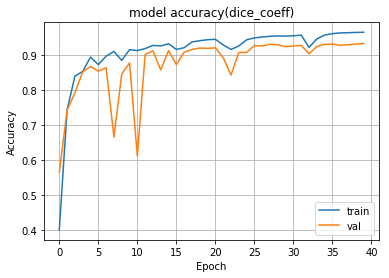

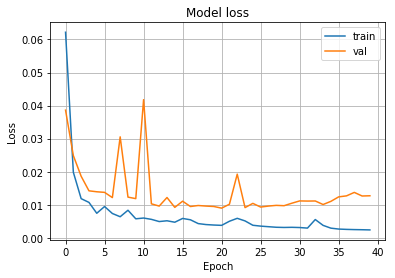

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_256_128b_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.021778802594801687 , 0.9456171956106355
val_loss  :  0.25363561266758405 , 0.013080363726762474
loss  :  0.46370498925493336 , 0.004115790028599071
val_dice_coeff  :  0.02914493323349562 , 0.900786687116154
------------------------------
------------------------------


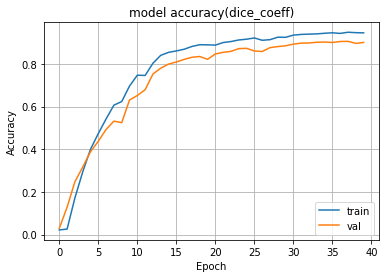

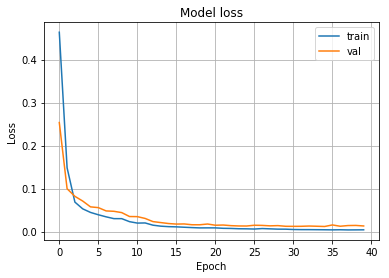

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_256_64b_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.01978656838888378 , 0.9610677904933461
val_loss  :  0.11198709367728624 , 0.01448806315721547
val_dice_coeff  :  0.09197646526039624 , 0.9237178994006798
loss  :  0.313243539853852 , 0.002896115694528569
------------------------------
------------------------------


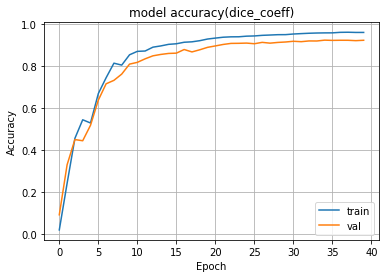

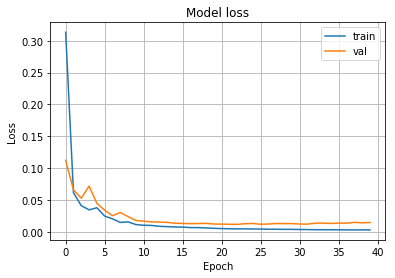

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_256_32b_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.10884301219168495 , 0.9683673352140717
val_loss  :  0.06655380410737678 , 0.015003381022175804
loss  :  0.18519196286606385 , 0.002352932341666314
val_dice_coeff  :  0.2902021725646785 , 0.9312442247984839
------------------------------
------------------------------


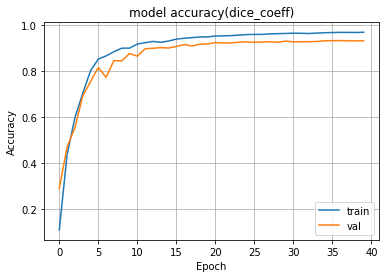

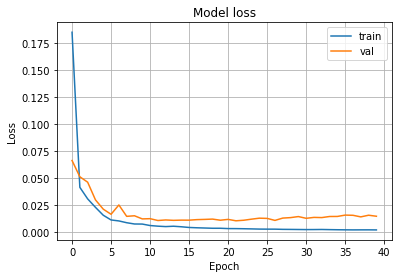

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_256_16b_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.2687088604157093 , 0.9711427178182255
val_loss  :  0.0549353726941054 , 0.016200033062305608
val_dice_coeff  :  0.40853244847938663 , 0.9342591352150088
loss  :  0.11415503265239631 , 0.0021204245330506853
------------------------------
------------------------------


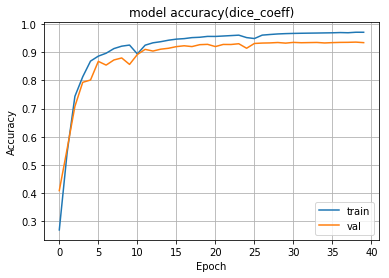

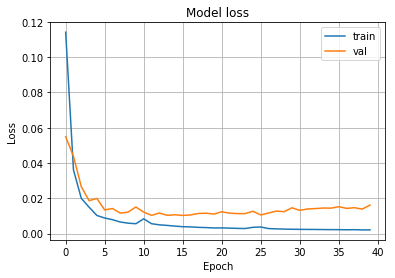

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_256_8b_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.3293301193715113 , 0.9664044070696451
val_loss  :  0.07337159480227799 , 0.013749012593790645
loss  :  0.08362610057080447 , 0.002420713439208191
val_dice_coeff  :  0.28719806622286315 , 0.9331536693651168
------------------------------
------------------------------


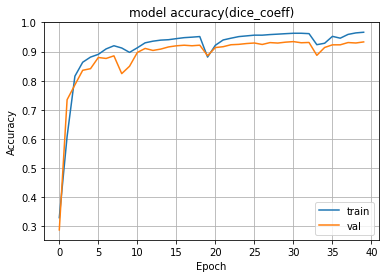

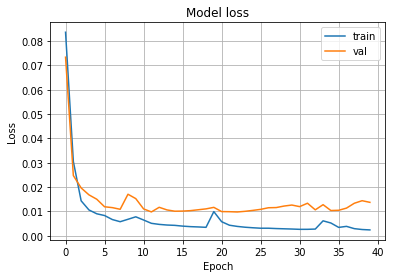

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_256_aug_dropout_64b_lr_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.037630293582814084 , 0.9593112835399673
val_loss  :  0.11542166464152884 , 0.014002768750317762
val_dice_coeff  :  0.16732677499778936 , 0.9240137836972221
loss  :  0.2055982697684377 , 0.003054027383972156
------------------------------
------------------------------


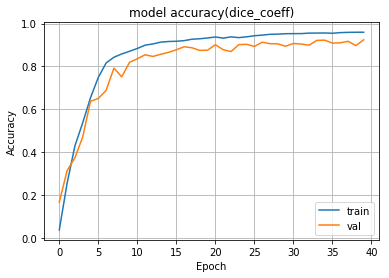

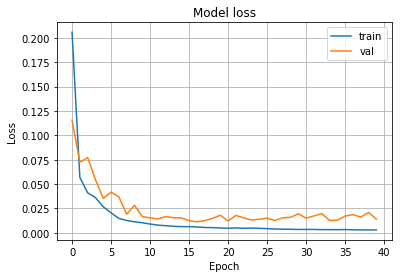

In [16]:
for history_file in hist_file_256:
    print ('='*30)
    print ('='*30)
    print ("Learning history of :" + history_file)
    print ('-'*30)

    plot_accuracy_and_loss(history_file)   

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_176_dropout_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.4606630476200749 , 0.9618993241582668
val_loss  :  0.07837032288557193 , 0.025585425506177983
val_dice_coeff  :  0.6541407130292205 , 0.9355345006848945
loss  :  0.10263564284000185 , 0.005375517680839645
------------------------------
------------------------------


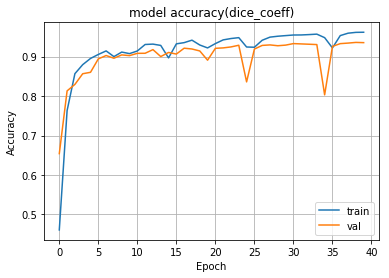

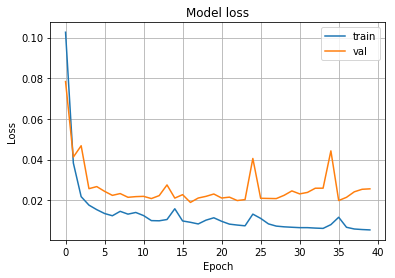

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_176_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.44290062644518435 , 0.9671809421006443
val_loss  :  0.10823427470492535 , 0.0312542337924242
loss  :  0.10396305791242359 , 0.0047202838117446945
val_dice_coeff  :  0.5376197168084441 , 0.9334162439479202
------------------------------
------------------------------


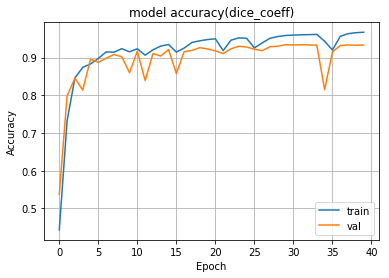

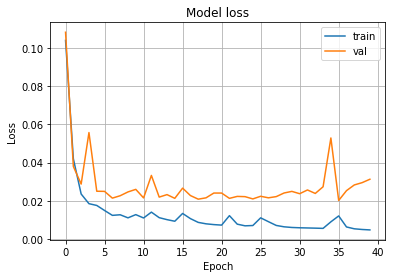

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_176_aug_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.3314285868460579 , 0.9721294152180069
val_loss  :  0.09839775474345097 , 0.03592822554170108
loss  :  0.15675709257834136 , 0.004248187235729045
val_dice_coeff  :  0.5018956705195005 , 0.9388314876400057
------------------------------
------------------------------


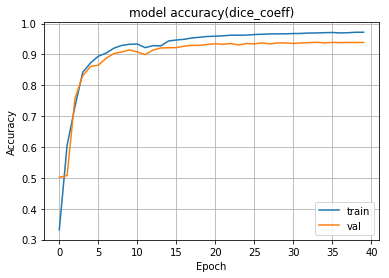

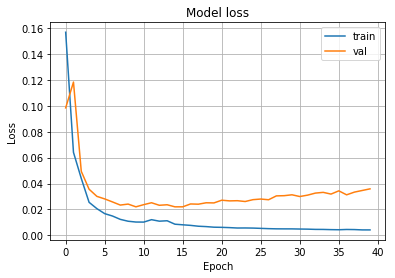

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_176_dropout_64b_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.07994013185731841 , 0.9633243346654677
val_loss  :  0.14968612961104658 , 0.0413813801696066
loss  :  0.2930285974901233 , 0.005685693139029718
val_dice_coeff  :  0.30310404251833434 , 0.9201092983855576
------------------------------
------------------------------


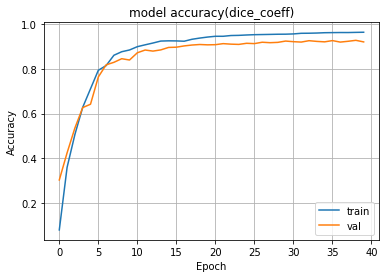

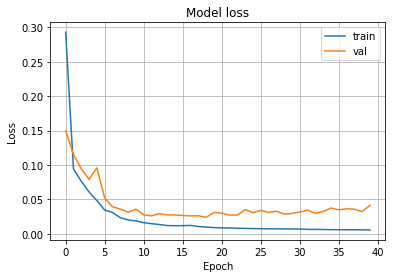

Learning history of :/masvol/heartsmart/unet_model/data/combined_1_2_176_aug_dropout_64b_lr_learning_history.json
------------------------------
------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.07194234268131043 , 0.963312917210739
val_loss  :  0.15784828828983619 , 0.034699513347911055
val_dice_coeff  :  0.28778905604706434 , 0.9269515139157655
loss  :  0.29799926772201407 , 0.00570477506699181
------------------------------
------------------------------


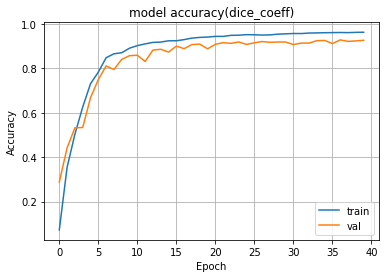

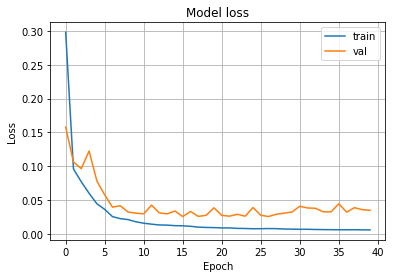

In [17]:
for history_file in hist_file:
    print ('='*30)
    print ('='*30)
    print ("Learning history of :" + history_file)
    print ('-'*30)

    plot_accuracy_and_loss(history_file)

In [18]:
# label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_labels.npy"
# pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_predictions.npy"
# y_true_f = np.load(label_file)
# y_pred_f = np.load(pred_file)
# p = get_performance_statistics(y_true_f, y_pred_f)
# print (p)

In [19]:
# perf_file = "perf_values.json"
# print ("Saving Performance values", perf_file)
# with open(perf_file, 'w') as file:
#     json.dump(p, file, indent=2)
# print('-'*30)

## Analysis on training with 256x256  combined data set (ACDC + Sunnybrook)
### Below are the results of 4 tests
1. Training with combined dataset
2. Training with combined dataset + Augmentation
3. Training with combined dataset (no augmentation),  using Unet with dropout layers
4. Training with combined dataset + Augmentation,  using Unet with dropout layers

In [20]:
hist_file_256

['/masvol/heartsmart/unet_model/data/combined_1_2_256_aug_learning_history.json',
 '/masvol/heartsmart/unet_model/data/combined_1_2_256_128b_learning_history.json',
 '/masvol/heartsmart/unet_model/data/combined_1_2_256_64b_learning_history.json',
 '/masvol/heartsmart/unet_model/data/combined_1_2_256_32b_learning_history.json',
 '/masvol/heartsmart/unet_model/data/combined_1_2_256_16b_learning_history.json',
 '/masvol/heartsmart/unet_model/data/combined_1_2_256_8b_learning_history.json',
 '/masvol/heartsmart/unet_model/data/combined_1_2_256_aug_dropout_64b_lr_learning_history.json']

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.39975264028250573 , 0.9653487980151678
val_loss  :  0.038619980933602714 , 0.012718351775413899
val_dice_coeff  :  0.5650916426885323 , 0.9332628176837671
loss  :  0.062190830464804094 , 0.002386274220963788
------------------------------
------------------------------


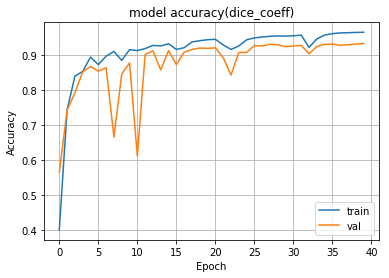

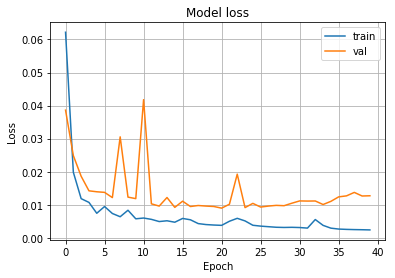

Number of Samples : 270, image size : 256 x 256 
before len:  270 270
after len:  270 270
Index removed [70, 31]
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [31, 70, 89, 92]
Sample Index of predictions with zero contours [31, 70, 86, 135, 162, 176, 216]
max-sigmoid values with zero contours [0.0013732349, 0.41246462, 0.00040337082, 0.002603932, 0.0012530979, 0.008354617, 0.08169432]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 2 [236, 242]
Sample Index where missed predictions >25% 33 [20, 39, 55, 65, 72, 73, 86, 89, 92, 95, 113, 123, 124, 135, 139, 153, 162, 167, 171, 176, 179, 189, 195, 197, 203, 207, 216, 230, 250, 251, 257, 258, 268]
Sample Index where missed predictions >50% 18 [39, 55, 65, 73, 86, 89, 92, 95, 124, 135, 139, 162, 171, 176, 207, 216, 251, 258]
Sample Index where missed pre

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:481: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:481: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:482: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:484: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:488: RuntimeWarning: invalid value encountered in greater_equal


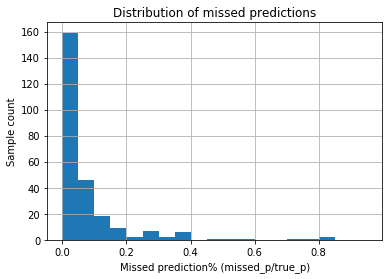

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


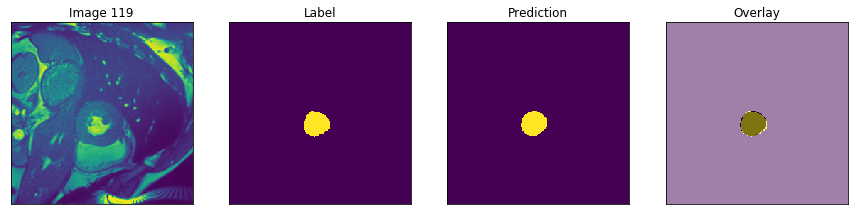

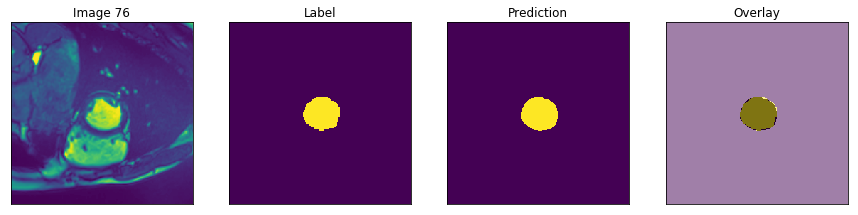

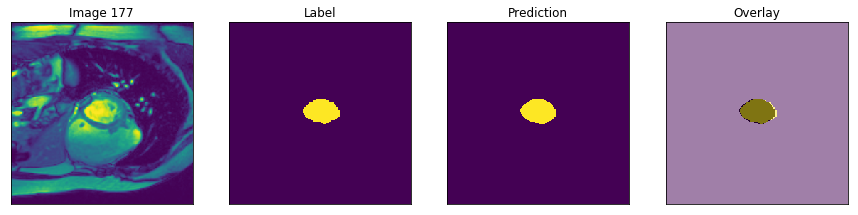

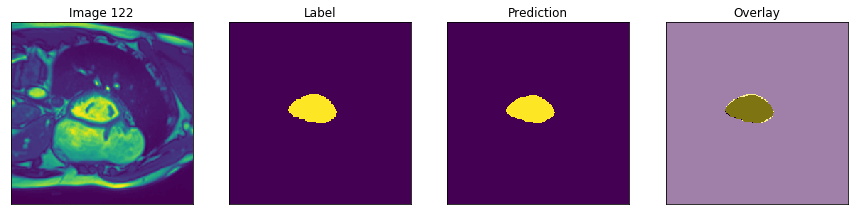

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


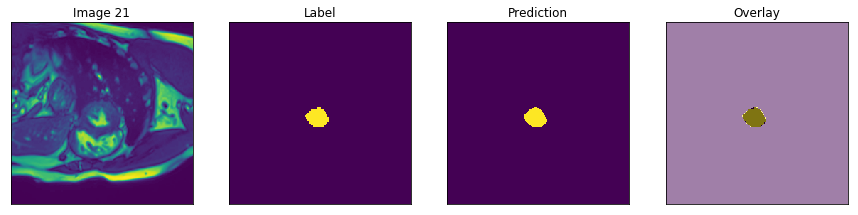

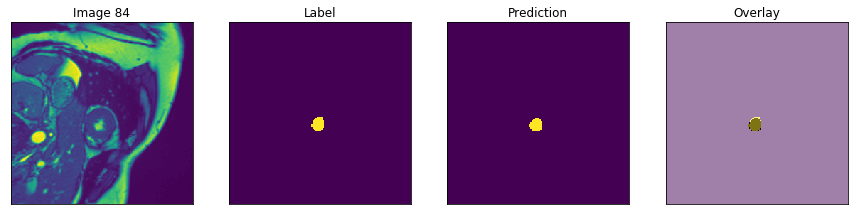

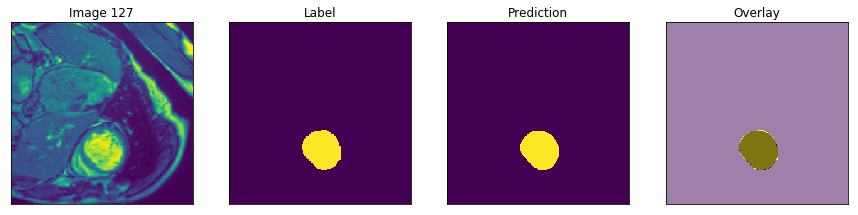

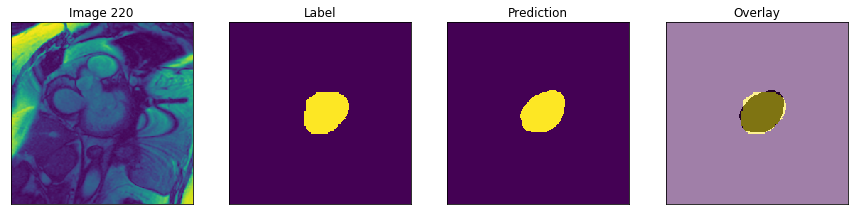

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.021778802594801687 , 0.9456171956106355
val_loss  :  0.25363561266758405 , 0.013080363726762474
loss  :  0.46370498925493336 , 0.004115790028599071
val_dice_coeff  :  0.02914493323349562 , 0.900786687116154
------------------------------
------------------------------


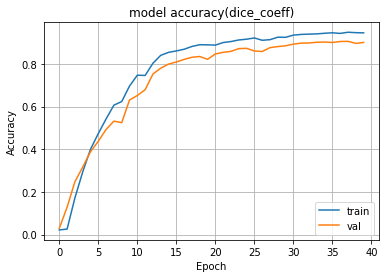

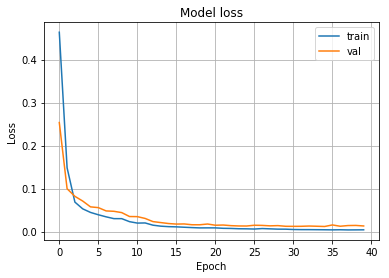

Number of Samples : 270, image size : 256 x 256 
before len:  270 270
after len:  270 270
Index removed [31]
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [31, 70, 89, 92]
Sample Index of predictions with zero contours [31, 74, 124, 135, 216]
max-sigmoid values with zero contours [0.06403216, 0.3012962, 0.014600651, 0.017110424, 0.068575114]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 1 [29]
Sample Index where missed predictions >25% 60 [3, 9, 12, 17, 18, 19, 20, 39, 55, 63, 65, 67, 70, 72, 73, 74, 79, 83, 86, 89, 92, 95, 113, 117, 121, 123, 124, 135, 138, 139, 146, 153, 161, 162, 164, 171, 172, 175, 176, 179, 180, 181, 183, 185, 188, 192, 193, 195, 198, 204, 206, 216, 230, 246, 250, 251, 254, 257, 258, 268]
Sample Index where missed predictions >50% 33 [9, 18, 20, 65, 70, 72, 73, 74, 89, 92, 9

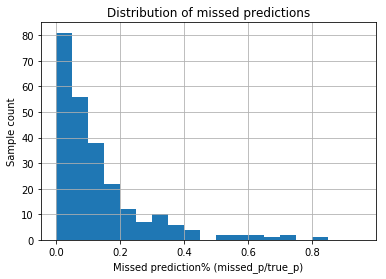

------------------------------
------------------------------
samples, max, min  270 0.999998 0.0


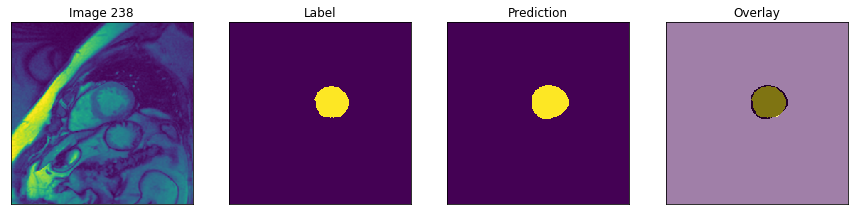

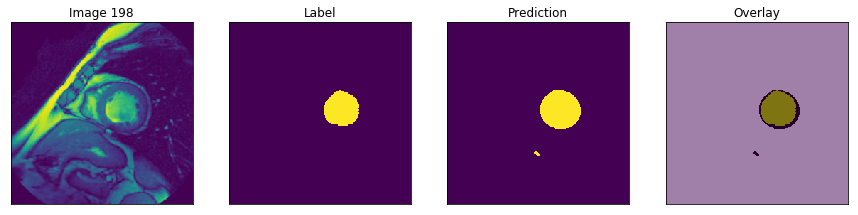

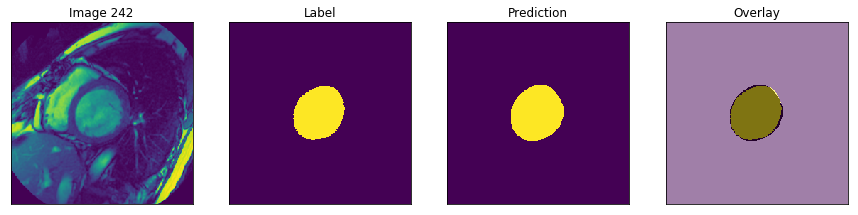

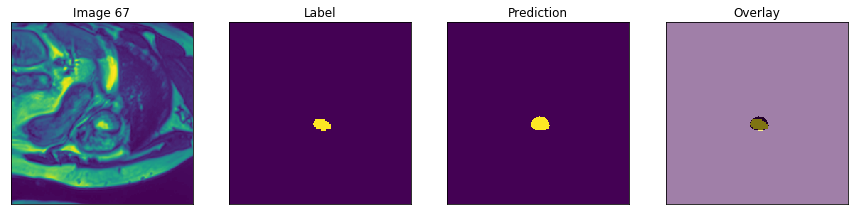

------------------------------
------------------------------
samples, max, min  270 0.999998 0.0


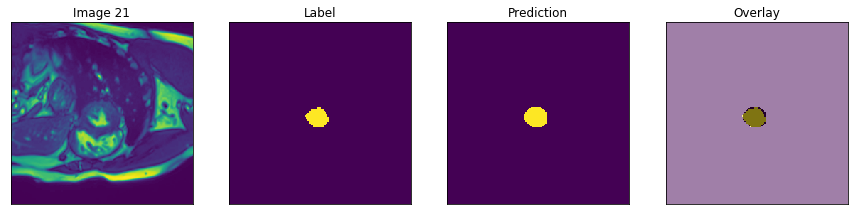

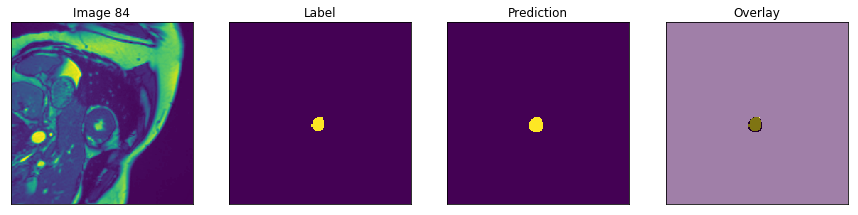

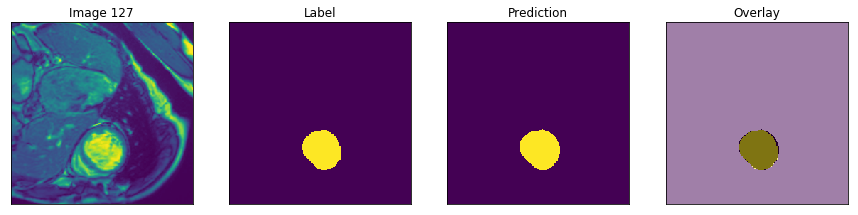

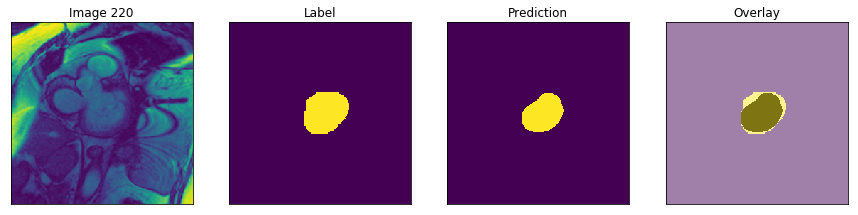

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.01978656838888378 , 0.9610677904933461
val_loss  :  0.11198709367728624 , 0.01448806315721547
val_dice_coeff  :  0.09197646526039624 , 0.9237178994006798
loss  :  0.313243539853852 , 0.002896115694528569
------------------------------
------------------------------


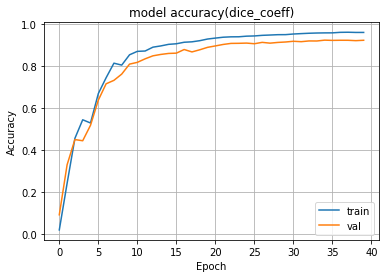

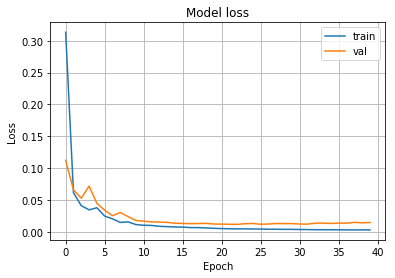

Number of Samples : 270, image size : 256 x 256 
before len:  270 270
after len:  270 270
Index removed [31]
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [31, 70, 89, 92]
Sample Index of predictions with zero contours [31, 55, 124, 135, 162, 216]
max-sigmoid values with zero contours [0.085411906, 0.19395982, 0.009083338, 0.06846503, 0.07549392, 0.35283208]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 2 [154, 165]
Sample Index where missed predictions >25% 53 [3, 9, 12, 17, 18, 19, 20, 39, 55, 58, 65, 67, 70, 72, 73, 74, 83, 84, 86, 89, 92, 95, 113, 117, 121, 123, 124, 135, 138, 139, 162, 167, 171, 176, 179, 181, 183, 187, 188, 192, 197, 198, 206, 207, 216, 223, 230, 250, 251, 254, 257, 258, 268]
Sample Index where missed predictions >50% 33 [9, 12, 18, 20, 55, 65, 70, 72, 73, 74, 86, 89, 92, 9

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


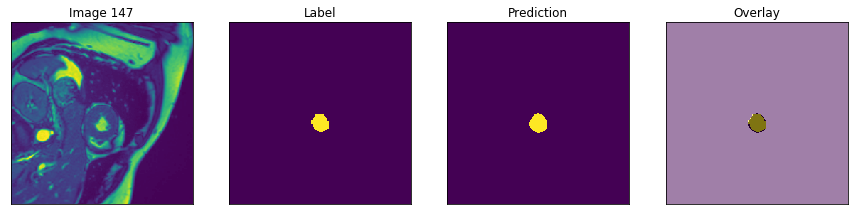

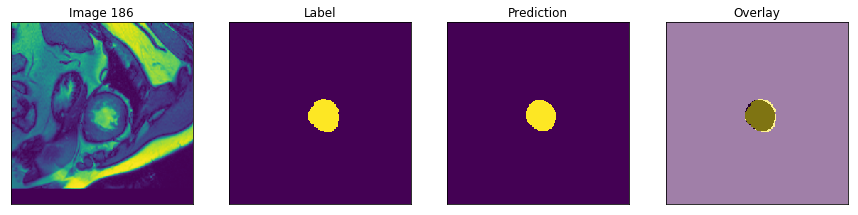

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


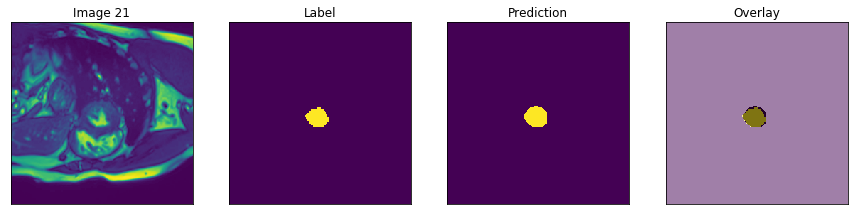

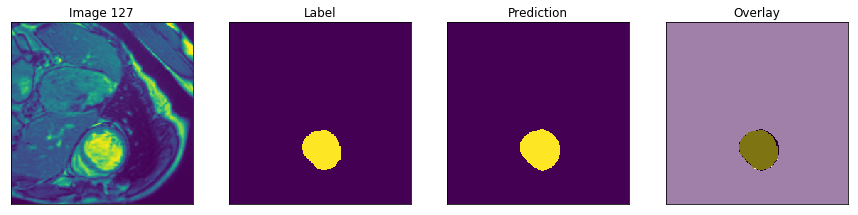

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.10884301219168495 , 0.9683673352140717
val_loss  :  0.06655380410737678 , 0.015003381022175804
loss  :  0.18519196286606385 , 0.002352932341666314
val_dice_coeff  :  0.2902021725646785 , 0.9312442247984839
------------------------------
------------------------------


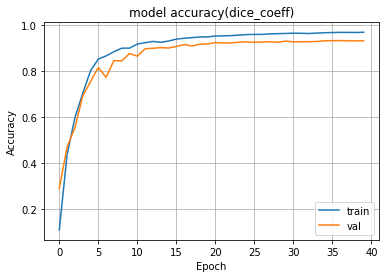

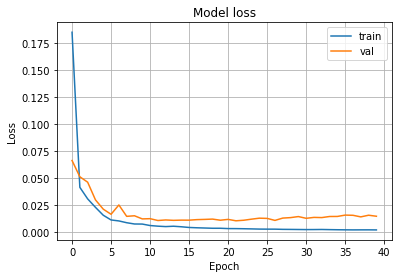

Number of Samples : 270, image size : 256 x 256 
before len:  270 270
after len:  270 270
Index removed [31]
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [31, 70, 89, 92]
Sample Index of predictions with zero contours [31, 86, 124, 135, 162, 176, 216]
max-sigmoid values with zero contours [0.21170168, 0.34484679, 0.20149527, 0.10501195, 0.057640158, 0.36696452, 0.20675366]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 4 [8, 47, 114, 217]
Sample Index where missed predictions >25% 39 [3, 12, 18, 19, 20, 39, 55, 65, 67, 70, 72, 73, 74, 86, 89, 92, 95, 113, 117, 121, 124, 135, 139, 162, 171, 176, 192, 198, 203, 206, 207, 216, 223, 230, 250, 251, 257, 258, 268]
Sample Index where missed predictions >50% 27 [12, 18, 39, 55, 65, 70, 72, 73, 74, 86, 89, 92, 95, 113, 121, 124, 135, 139, 162, 171, 176, 1

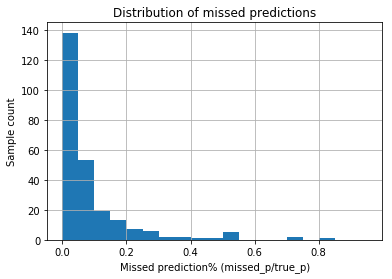

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


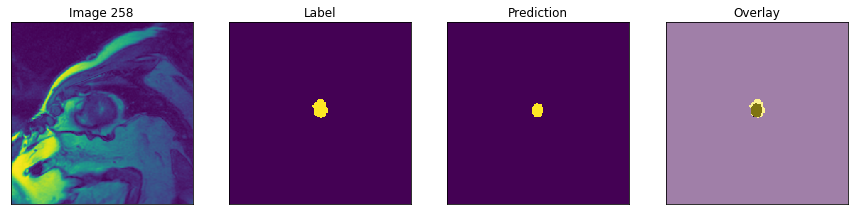

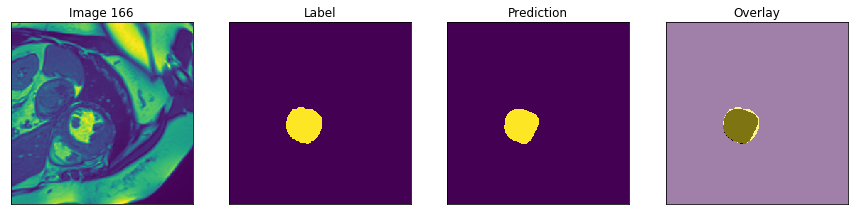

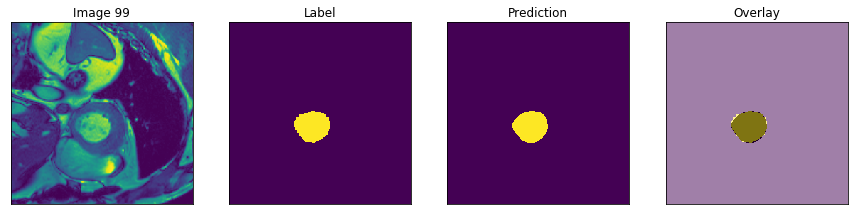

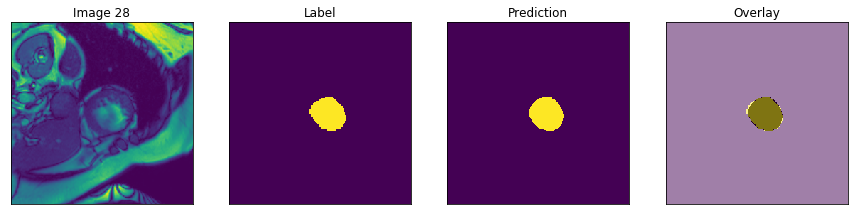

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


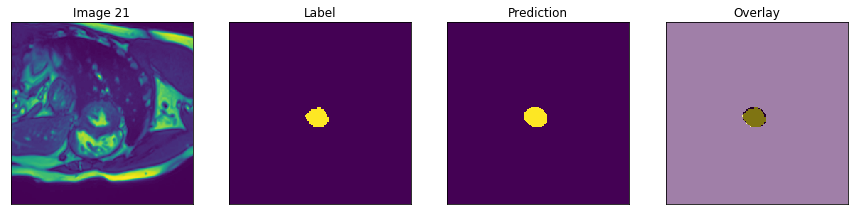

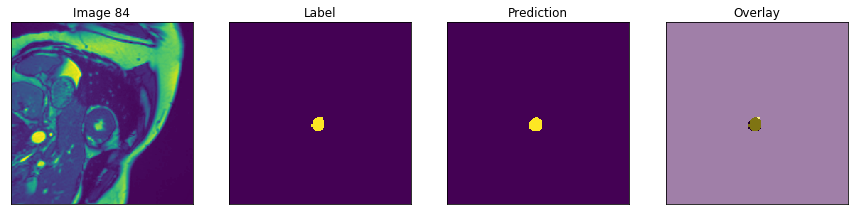

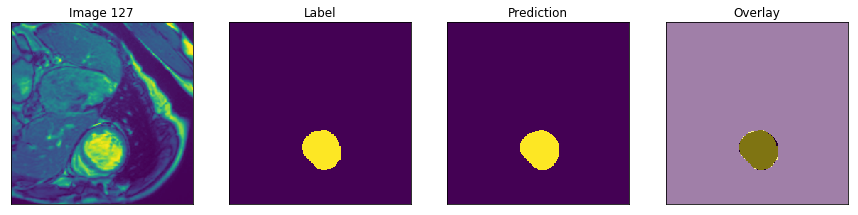

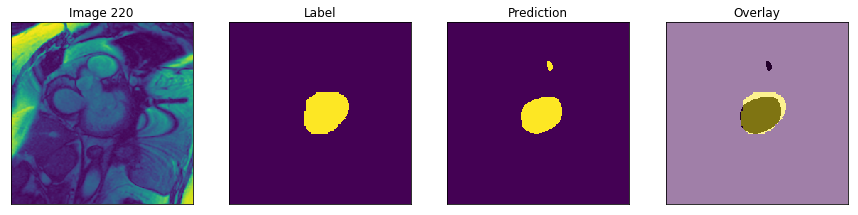

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.2687088604157093 , 0.9711427178182255
val_loss  :  0.0549353726941054 , 0.016200033062305608
val_dice_coeff  :  0.40853244847938663 , 0.9342591352150088
loss  :  0.11415503265239631 , 0.0021204245330506853
------------------------------
------------------------------


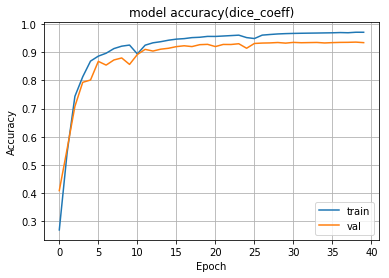

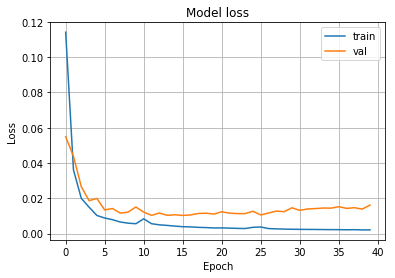

Number of Samples : 270, image size : 256 x 256 
before len:  270 270
after len:  270 270
Index removed [31]
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [31, 70, 89, 92]
Sample Index of predictions with zero contours [18, 31, 55, 86, 124, 135, 162, 171, 176, 216]
max-sigmoid values with zero contours [0.07822366, 0.00029802835, 0.053118303, 0.4956021, 0.26745012, 0.008715368, 0.2556065, 0.24517833, 0.10991357, 0.18919623]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 0 []
Sample Index where missed predictions >25% 35 [18, 20, 39, 55, 58, 63, 65, 67, 70, 72, 73, 74, 86, 89, 92, 95, 113, 124, 135, 139, 162, 167, 171, 176, 197, 203, 206, 207, 216, 230, 243, 251, 257, 258, 268]
Sample Index where missed predictions >50% 22 [18, 39, 55, 65, 70, 72, 74, 86, 89, 92, 95, 113, 124, 135, 139, 162, 171, 1

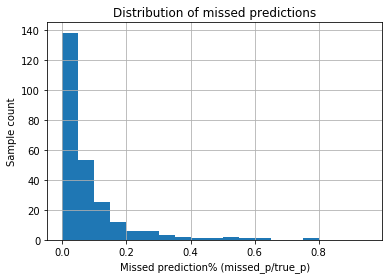

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


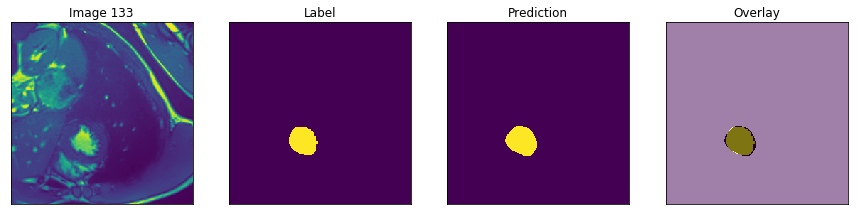

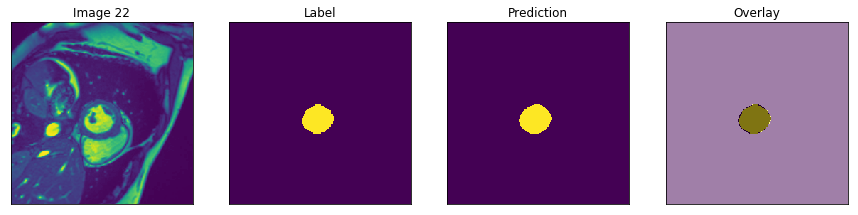

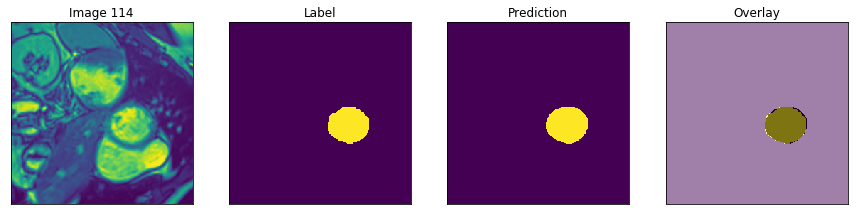

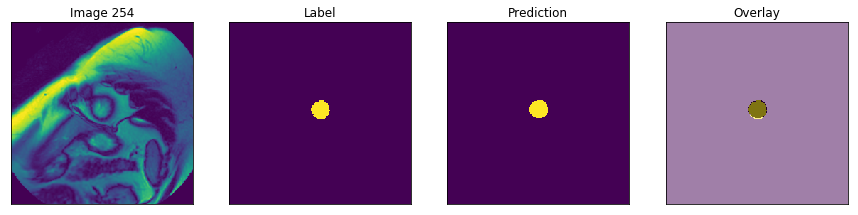

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


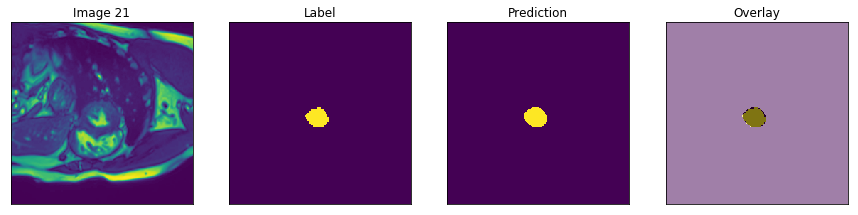

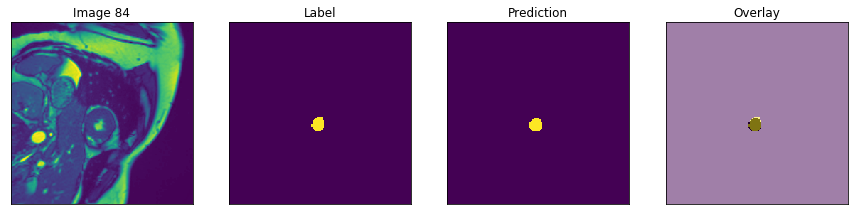

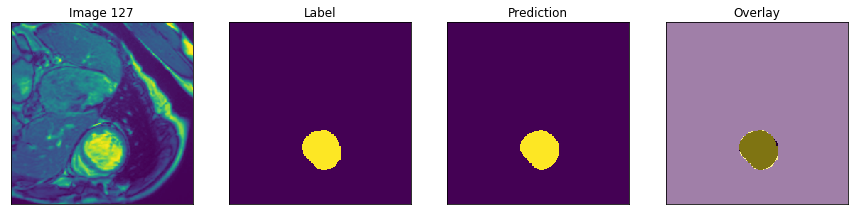

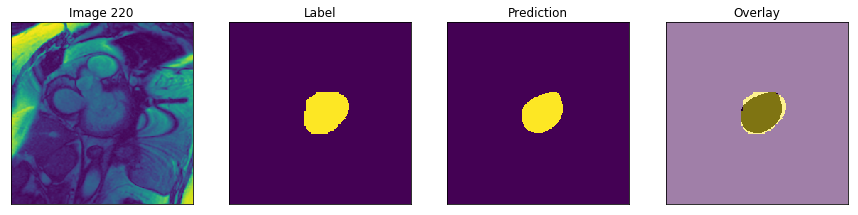

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.3293301193715113 , 0.9664044070696451
val_loss  :  0.07337159480227799 , 0.013749012593790645
loss  :  0.08362610057080447 , 0.002420713439208191
val_dice_coeff  :  0.28719806622286315 , 0.9331536693651168
------------------------------
------------------------------


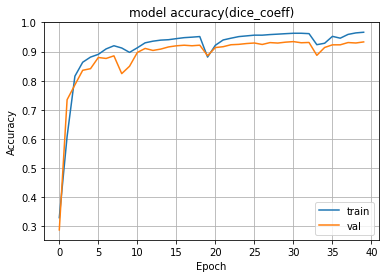

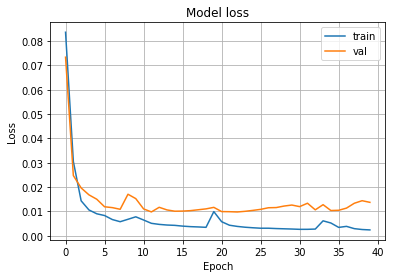

Number of Samples : 270, image size : 256 x 256 
before len:  270 270
after len:  270 270
Index removed [31]
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [31, 70, 89, 92]
Sample Index of predictions with zero contours [31, 86, 162, 176, 216]
max-sigmoid values with zero contours [0.021761086, 0.19130518, 0.4225895, 0.017999858, 0.0039775674]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 3 [51, 98, 168]
Sample Index where missed predictions >25% 29 [12, 18, 55, 65, 67, 70, 72, 73, 74, 86, 89, 92, 95, 113, 117, 124, 135, 139, 162, 171, 176, 203, 207, 216, 223, 250, 251, 258, 268]
Sample Index where missed predictions >50% 20 [18, 55, 65, 70, 86, 89, 92, 95, 113, 124, 135, 139, 162, 176, 207, 216, 223, 251, 258, 268]
Sample Index where missed predictions >= 100% 12 [65, 70, 86, 89, 92, 95, 113, 139

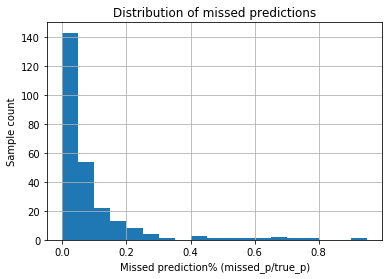

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


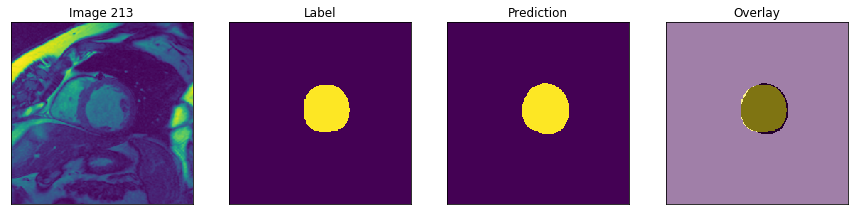

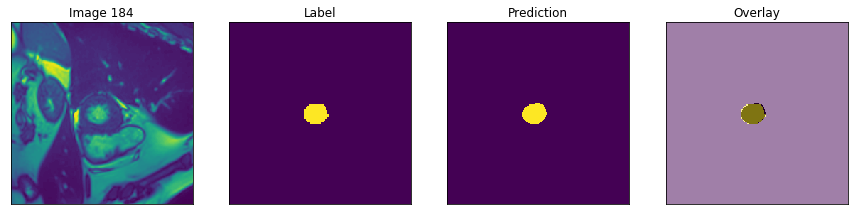

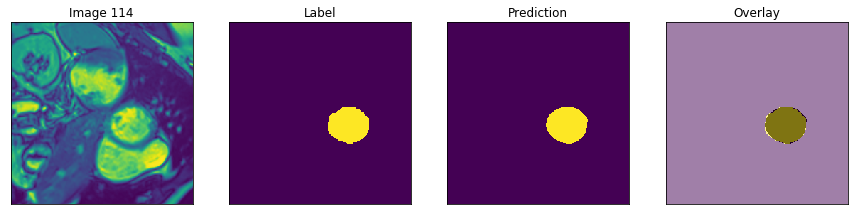

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


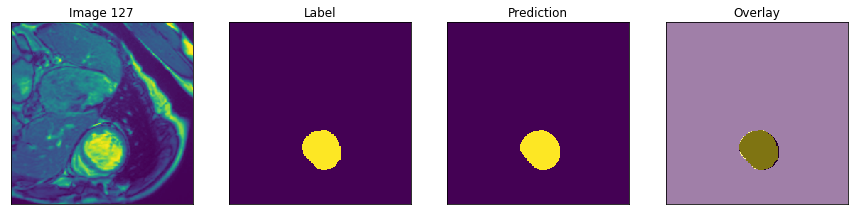

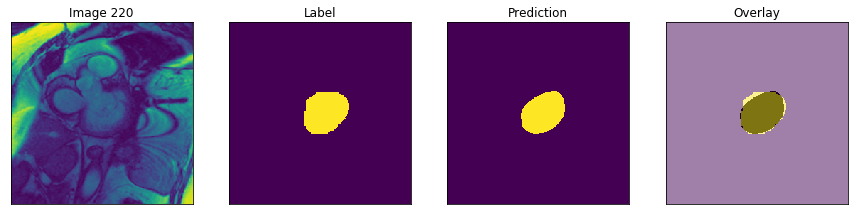

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.037630293582814084 , 0.9593112835399673
val_loss  :  0.11542166464152884 , 0.014002768750317762
val_dice_coeff  :  0.16732677499778936 , 0.9240137836972221
loss  :  0.2055982697684377 , 0.003054027383972156
------------------------------
------------------------------


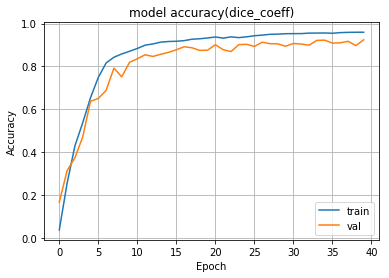

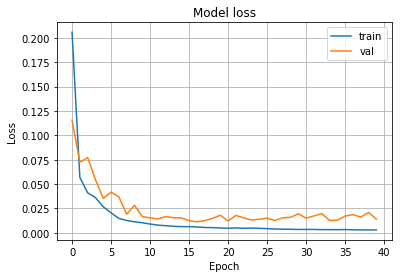

Number of Samples : 270, image size : 256 x 256 
before len:  270 270
after len:  270 270
Index removed []
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [31, 70, 89, 92]
Sample Index of predictions with zero contours [12, 55, 74, 124, 135, 216]
max-sigmoid values with zero contours [0.27369896, 0.23118551, 0.26330376, 0.12022269, 0.0061792643, 0.49722284]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 1 [122]
Sample Index where missed predictions >25% 65 [2, 3, 12, 17, 18, 19, 20, 21, 31, 35, 40, 55, 58, 60, 63, 65, 66, 67, 70, 72, 74, 79, 83, 84, 86, 89, 92, 95, 96, 113, 117, 121, 123, 124, 135, 138, 139, 144, 146, 151, 153, 162, 164, 171, 176, 181, 183, 184, 185, 187, 188, 192, 193, 195, 197, 198, 206, 216, 223, 246, 250, 251, 257, 258, 268]
Sample Index where missed predictions >50% 29 [12, 18,

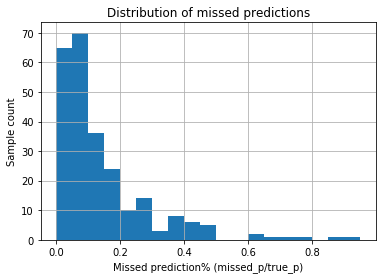

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


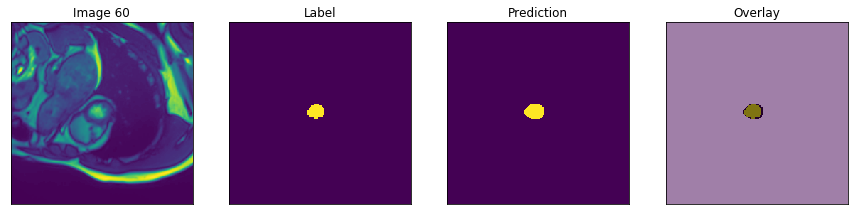

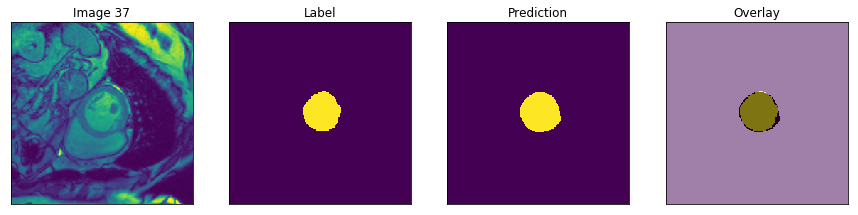

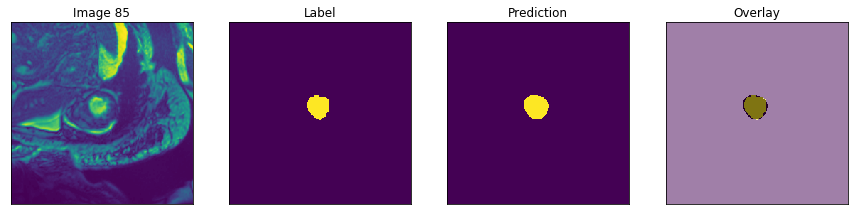

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


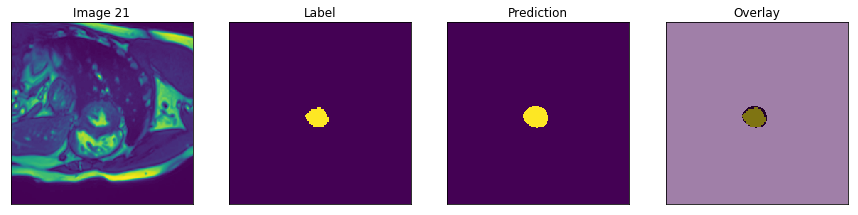

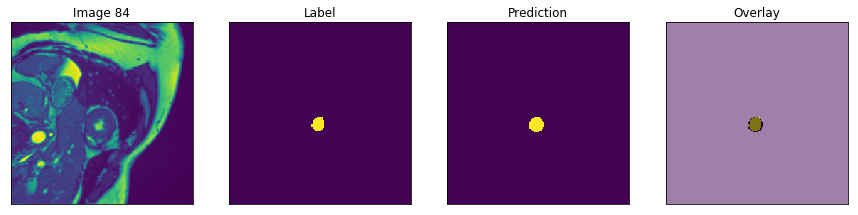

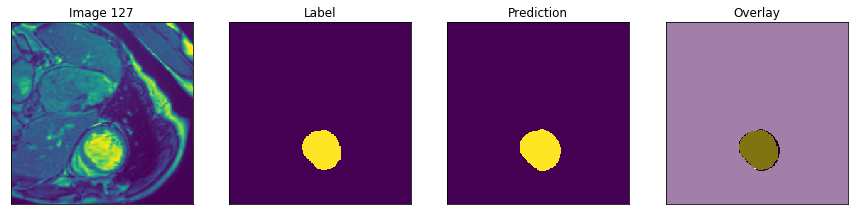

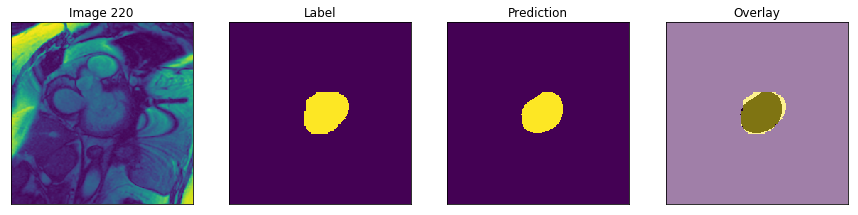

In [21]:
for i in range(len(hist_file_256)):
    hfile = hist_file_256[i]
    pfile = pred_file_256[i]
    plot_accuracy_and_loss(hfile)
    perf = compute_performance_statistics(label_file256, pfile)
    find_outliers(label_file256, pfile)
    display_images_labels_predictions (image_file256, label_file256, pfile, num_images = 4, random_images = True)
    print('-'*30)
    print('-'*30)
    zcontour = [21, 84, 127, 220]
    display_images_labels_predictions (image_file256, label_file256, pfile, image_list = zcontour)

In [22]:
#history_file = "/masvol/heartsmart/unet_model/data/combined_1_2_256_aug_learning_history.json"
#pred_file = "/masvol/heartsmart/unet_model/data/combined_1_2_256_aug_predictions.npy"
#plot_accuracy_and_loss(history_file)
#perf = compute_performance_statistics(label_file, pred_file)
#find_outliers(label_file, pred_file)
#display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
#print('-'*30)
#print('-'*30)
#zcontour = [21, 84, 127, 220]
#display_images_labels_predictions (image_file, label_file, pred_file, zcontour)

In [23]:
# history_file = "/masvol/heartsmart/unet_model/data/combined_1_2_256_dropout_learning_history.json"
# image_file = "/masvol/output/unet_training/combined_1_2_256_test_images.npy"
# label_file = "/masvol/output/unet_training/combined_1_2_256_test_labels.npy"
# pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_2_256_dropout_predictions.npy"
# plot_accuracy_and_loss(history_file)
# perf = compute_performance_statistics(label_file, pred_file)
# find_outliers(label_file, pred_file)
# display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
# print('-'*30)
# print('-'*30)
# zcontour = [21, 84, 127, 220]
# display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [24]:
# history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_drop_1_3_256_learning_history.json"
# image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_images.npy"
# label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_labels.npy"
# pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_drop_1_3_256_predictions.npy"
# plot_accuracy_and_loss(history_file)
# perf = compute_performance_statistics(label_file, pred_file)
# find_outliers(label_file, pred_file)
# display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
# print('-'*30)
# print('-'*30)
# zcontour = [11, 127, 165, 184, 192, 204, 217, 229]
# display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [25]:
# history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_drop_1_3_256_learning_history.json"
# image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_images.npy"
# label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_labels.npy"
# pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_drop_1_3_256_predictions.npy"
# plot_accuracy_and_loss(history_file)
# perf = compute_performance_statistics(label_file, pred_file)
# find_outliers(label_file, pred_file)
# display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
# print('-'*30)
# print('-'*30)
# zcontour = [11, 21, 22, 127, 192, 204, 217, 220]
# display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

## Analysis on training with 176x176  combined data set (ACDC + Sunnybrook)
### Below are the results of 4 tests
1. Training with combined dataset
2. Training with combined dataset + Augmentation
3. Training with combined dataset (no augmentation),  using Unet with dropout layers
4. Training with combined dataset + Augmentation,  using Unet with dropout layers

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.4606630476200749 , 0.9618993241582668
val_loss  :  0.07837032288557193 , 0.025585425506177983
val_dice_coeff  :  0.6541407130292205 , 0.9355345006848945
loss  :  0.10263564284000185 , 0.005375517680839645
------------------------------
------------------------------


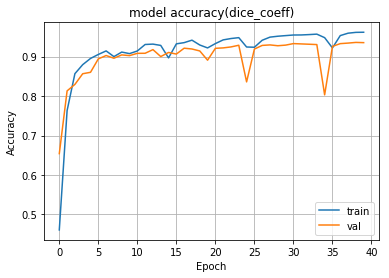

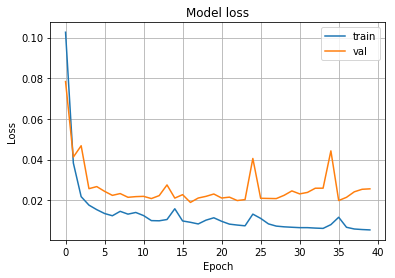

Number of Samples : 270, image size : 176 x 176 
before len:  270 270
after len:  270 270
Index removed [98, 70]
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [24, 70, 98]
Sample Index of predictions with zero contours [59, 70, 98, 154]
max-sigmoid values with zero contours [0.007485674, 0.040432975, 0.015827881, 0.00094283064]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 1 [168]
Sample Index where missed predictions >25% 28 [4, 10, 16, 18, 24, 48, 57, 59, 65, 66, 68, 69, 77, 84, 99, 154, 176, 178, 184, 186, 219, 225, 230, 234, 239, 243, 249, 252]
Sample Index where missed predictions >50% 11 [4, 10, 16, 18, 24, 48, 57, 59, 77, 154, 243]
Sample Index where missed predictions >= 100% 8 [4, 10, 24, 57, 59, 77, 154, 243]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:481: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:481: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:482: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:484: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:488: RuntimeWarning: invalid value encountered in greater_equal


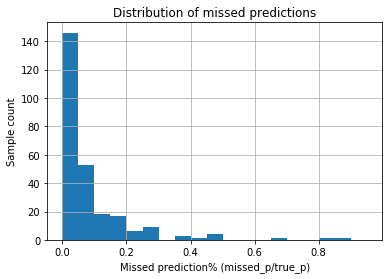

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


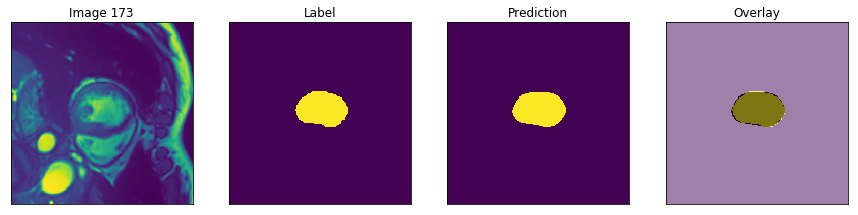

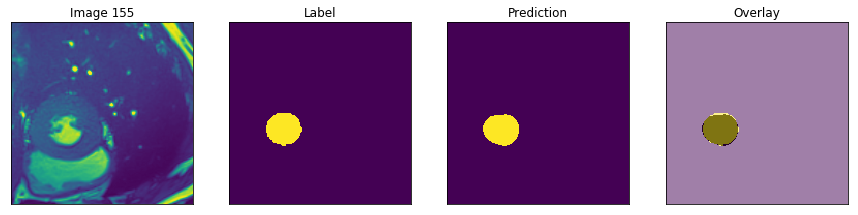

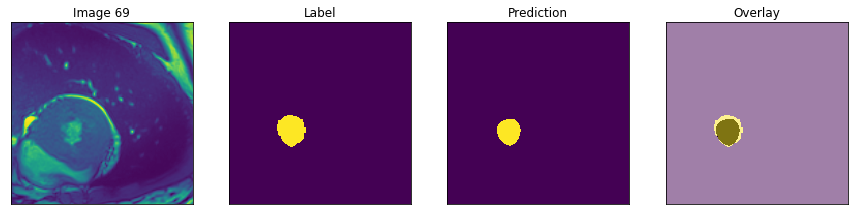

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


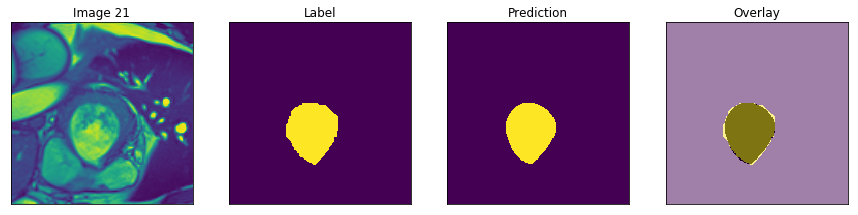

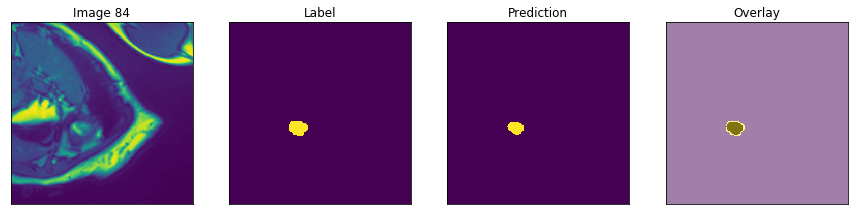

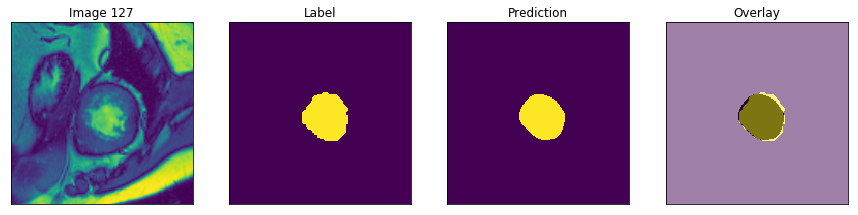

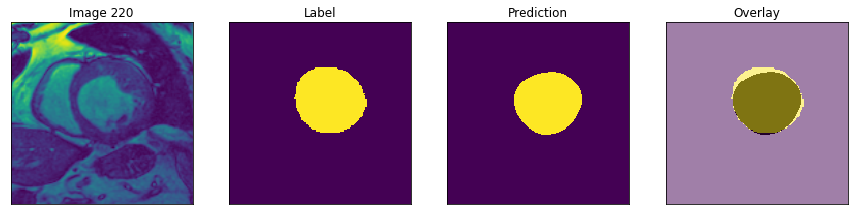

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.44290062644518435 , 0.9671809421006443
val_loss  :  0.10823427470492535 , 0.0312542337924242
loss  :  0.10396305791242359 , 0.0047202838117446945
val_dice_coeff  :  0.5376197168084441 , 0.9334162439479202
------------------------------
------------------------------


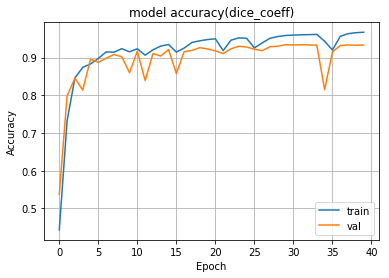

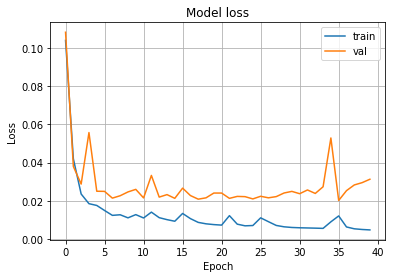

Number of Samples : 270, image size : 176 x 176 
before len:  270 270
after len:  270 270
Index removed [98, 70, 24]
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [24, 70, 98]
Sample Index of predictions with zero contours [24, 57, 59, 70, 98]
max-sigmoid values with zero contours [0.19301991, 0.23346502, 0.059197463, 0.065836824, 0.015909027]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 2 [137, 161]
Sample Index where missed predictions >25% 21 [4, 10, 15, 16, 48, 57, 59, 68, 77, 84, 106, 154, 176, 178, 186, 219, 230, 239, 243, 246, 249]
Sample Index where missed predictions >50% 16 [4, 10, 16, 48, 57, 59, 68, 77, 154, 176, 178, 219, 230, 243, 246, 249]
Sample Index where missed predictions >= 100% 5 [4, 57, 59, 77, 243]


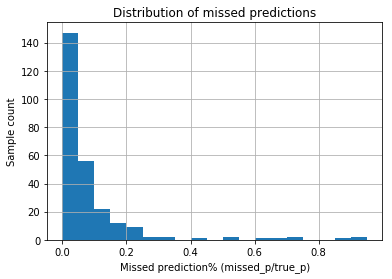

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


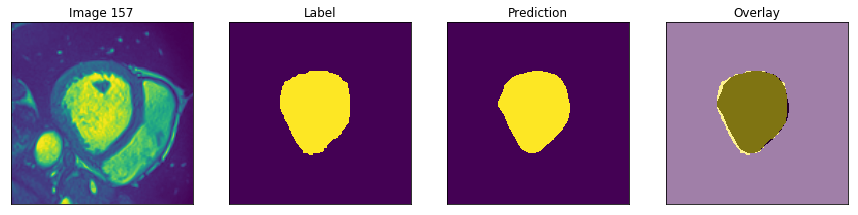

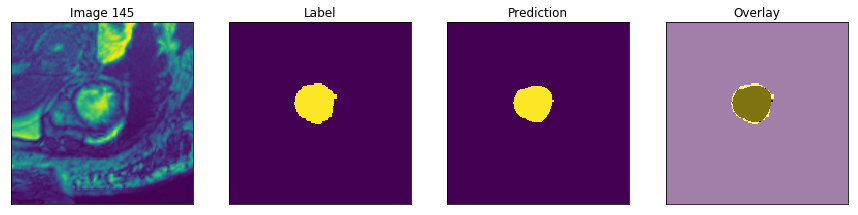

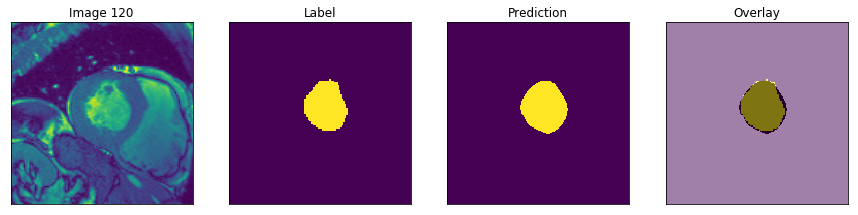

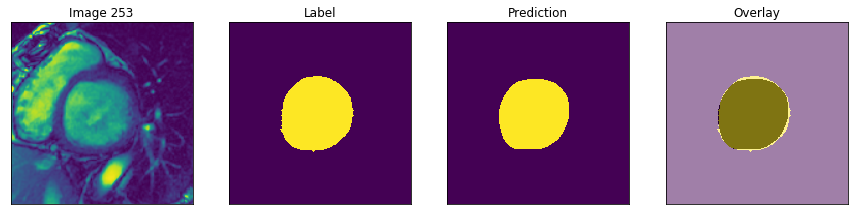

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


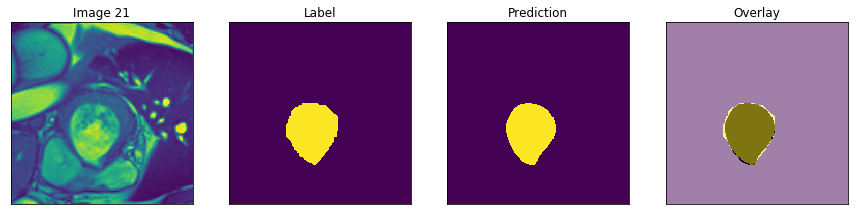

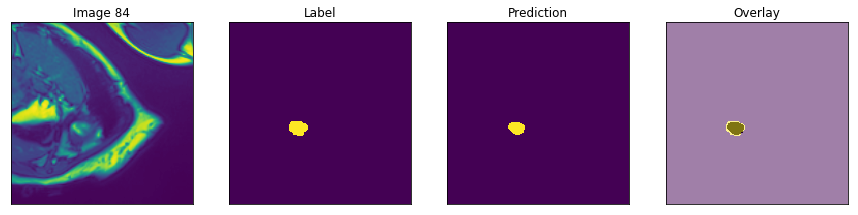

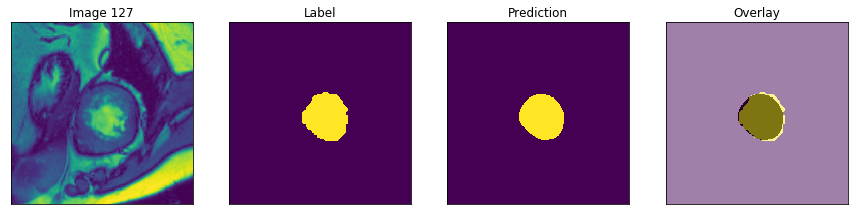

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.3314285868460579 , 0.9721294152180069
val_loss  :  0.09839775474345097 , 0.03592822554170108
loss  :  0.15675709257834136 , 0.004248187235729045
val_dice_coeff  :  0.5018956705195005 , 0.9388314876400057
------------------------------
------------------------------


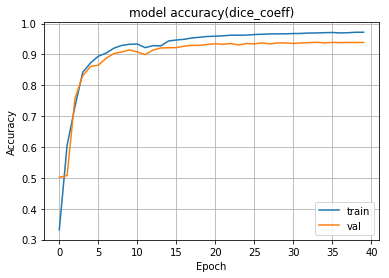

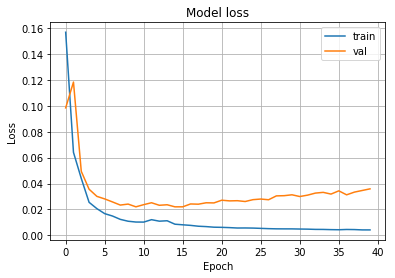

Number of Samples : 270, image size : 176 x 176 
before len:  270 270
after len:  270 270
Index removed [70]
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [24, 70, 98]
Sample Index of predictions with zero contours [16, 57, 59, 70, 154]
max-sigmoid values with zero contours [0.3653561, 0.05646862, 0.005757631, 0.061953172, 0.32852414]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 3 [81, 147, 266]
Sample Index where missed predictions >25% 26 [12, 15, 16, 18, 24, 48, 57, 59, 68, 69, 77, 84, 98, 102, 106, 153, 154, 161, 176, 178, 219, 225, 230, 239, 243, 249]
Sample Index where missed predictions >50% 15 [12, 16, 18, 24, 48, 57, 59, 68, 77, 98, 154, 176, 239, 243, 249]
Sample Index where missed predictions >= 100% 8 [16, 24, 57, 59, 77, 98, 154, 243]


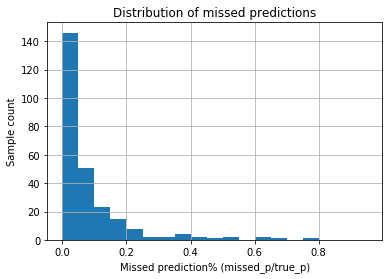

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


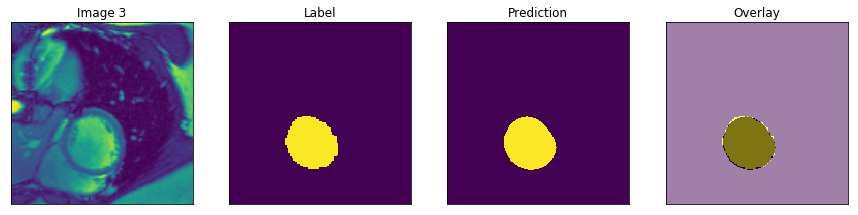

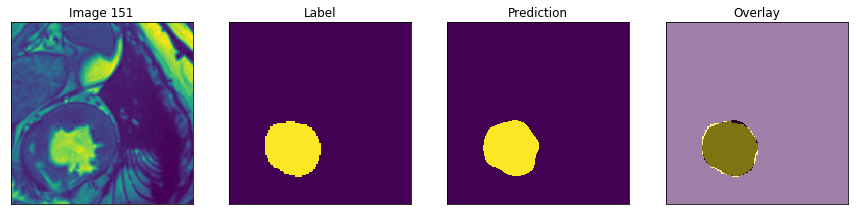

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


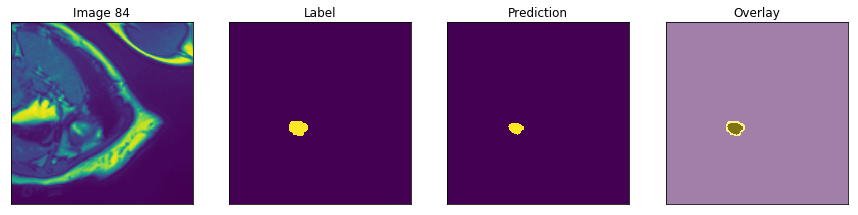

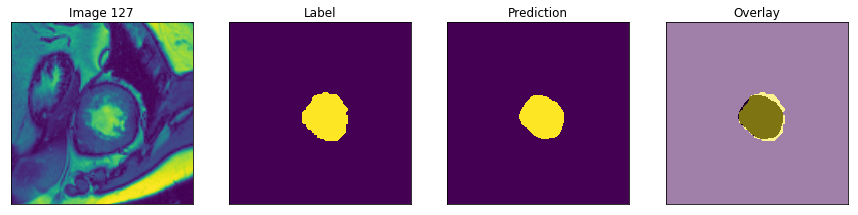

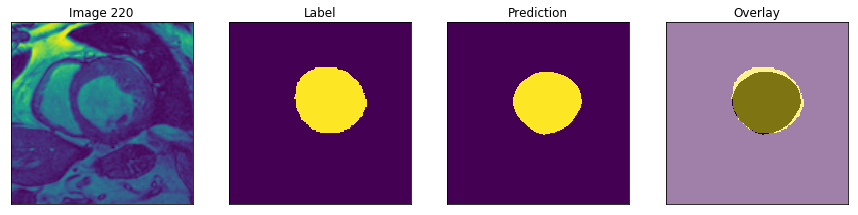

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.07994013185731841 , 0.9633243346654677
val_loss  :  0.14968612961104658 , 0.0413813801696066
loss  :  0.2930285974901233 , 0.005685693139029718
val_dice_coeff  :  0.30310404251833434 , 0.9201092983855576
------------------------------
------------------------------


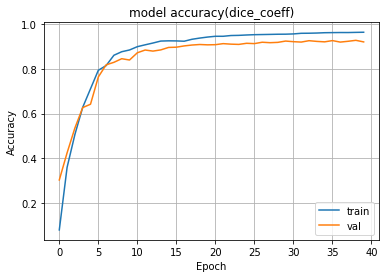

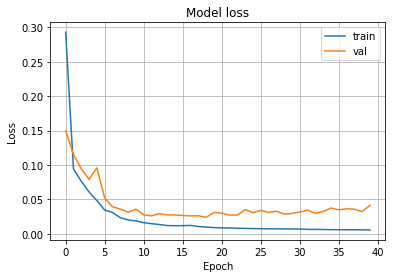

Number of Samples : 270, image size : 176 x 176 
before len:  270 270
after len:  270 270
Index removed []
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [24, 70, 98]
Sample Index of predictions with zero contours [59]
max-sigmoid values with zero contours [0.039685637]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 0 []
Sample Index where missed predictions >25% 45 [4, 10, 16, 18, 24, 33, 43, 48, 51, 52, 57, 59, 65, 68, 70, 73, 77, 84, 85, 88, 92, 97, 98, 101, 106, 133, 136, 154, 161, 176, 184, 186, 189, 201, 202, 204, 216, 218, 221, 231, 234, 237, 239, 243, 249]
Sample Index where missed predictions >50% 26 [4, 10, 16, 18, 24, 43, 48, 57, 59, 65, 68, 70, 77, 84, 88, 98, 133, 136, 161, 176, 202, 216, 237, 239, 243, 249]
Sample Index where missed predictions >= 100% 14 [10, 24, 59, 70, 77, 98, 133,

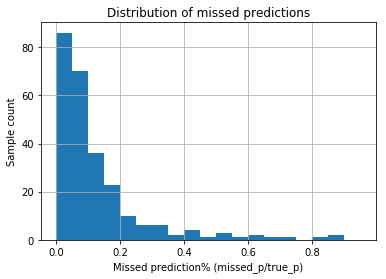

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


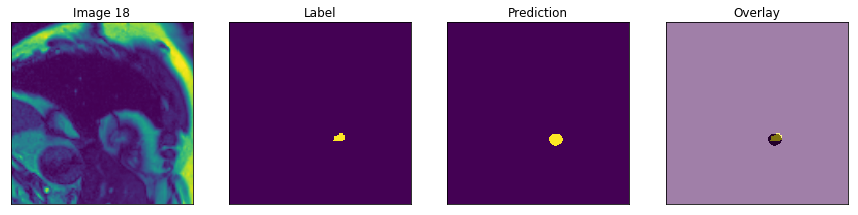

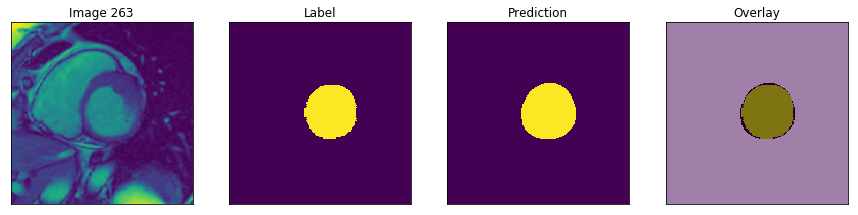

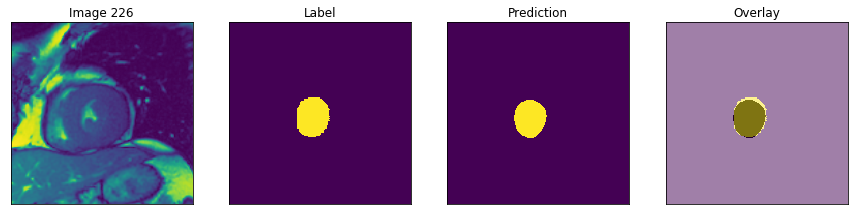

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


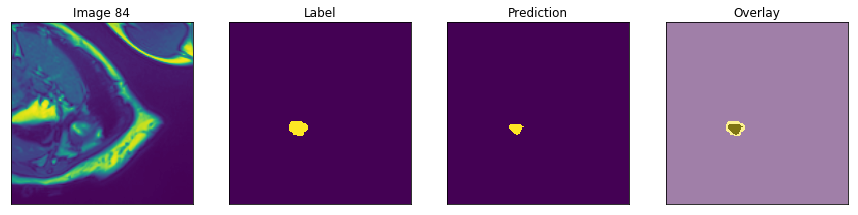

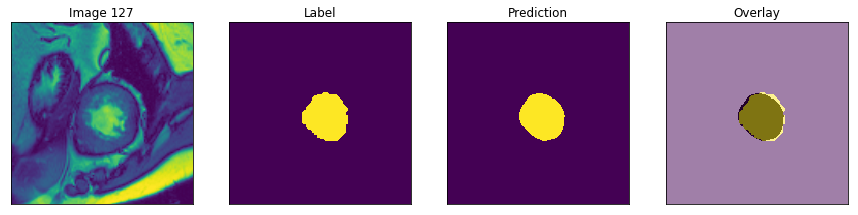

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.07194234268131043 , 0.963312917210739
val_loss  :  0.15784828828983619 , 0.034699513347911055
val_dice_coeff  :  0.28778905604706434 , 0.9269515139157655
loss  :  0.29799926772201407 , 0.00570477506699181
------------------------------
------------------------------


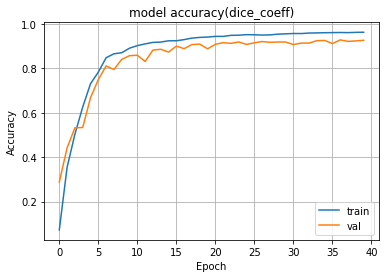

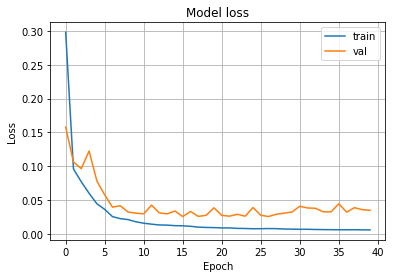

Number of Samples : 270, image size : 176 x 176 
before len:  270 270
after len:  270 270
Index removed []
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [24, 70, 98]
Sample Index of predictions with zero contours [16, 59]
max-sigmoid values with zero contours [0.35008937, 0.22118081]
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 0 []
Sample Index where missed predictions >25% 45 [4, 10, 11, 15, 16, 24, 27, 33, 43, 48, 52, 57, 59, 65, 68, 70, 77, 84, 85, 88, 92, 97, 98, 101, 106, 133, 136, 154, 161, 178, 184, 186, 189, 201, 202, 204, 216, 218, 219, 221, 225, 237, 239, 243, 249]
Sample Index where missed predictions >50% 22 [4, 10, 16, 24, 43, 48, 57, 59, 68, 70, 77, 98, 133, 136, 161, 202, 216, 219, 221, 239, 243, 249]
Sample Index where missed predictions >= 100% 11 [10, 16, 24, 59, 70, 77, 98, 2

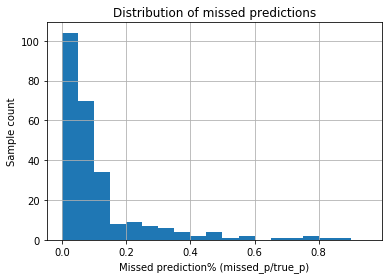

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


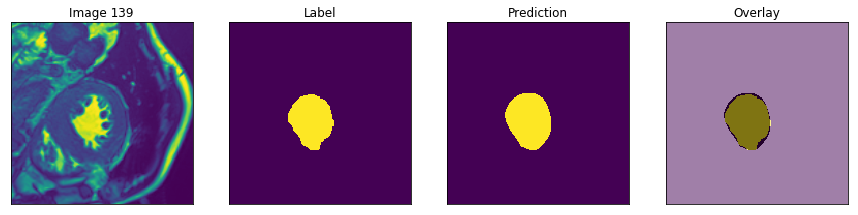

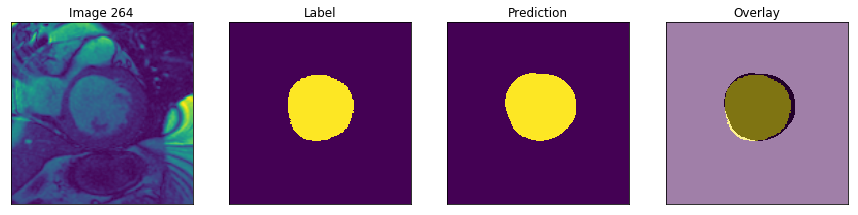

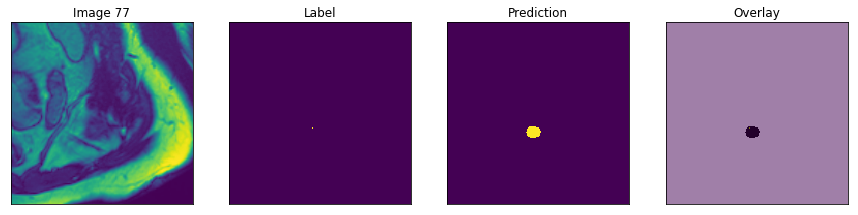

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


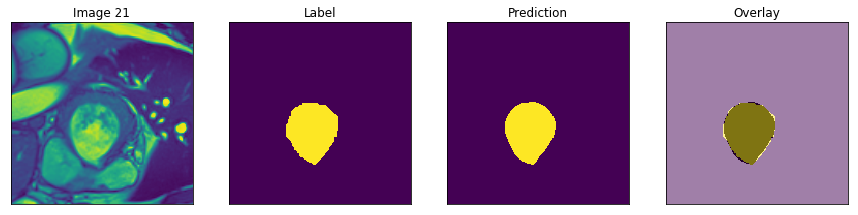

In [26]:
for i in range(len(hist_file)):
    hfile = hist_file[i]
    pfile = pred_file[i]
    plot_accuracy_and_loss(hfile)
    perf = compute_performance_statistics(label_file176, pfile)
    find_outliers(label_file176, pfile)
    display_images_labels_predictions (image_file176, label_file176, pfile, num_images = 4, random_images = True)
    print('-'*30)
    print('-'*30)
    zcontour = [21, 84, 127, 220]
    display_images_labels_predictions (image_file176, label_file176, pfile, image_list = zcontour)

In [27]:
# history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_learning_history.json"
# image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
# label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_labels.npy"
# pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_predictions.npy"
# plot_accuracy_and_loss(history_file)
# perf = compute_performance_statistics(label_file, pred_file)
# find_outliers(label_file, pred_file)
# display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
# print('-'*30)
# print('-'*30)
# zcontour = [47, 68, 81, 82, 141, 155, 173, 202, 213]
# display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [28]:
# history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_1_3_176_learning_history.json"
# image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
# label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_labels.npy"
# pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_1_3_176_predictions.npy"
# plot_accuracy_and_loss(history_file)
# perf = compute_performance_statistics(label_file, pred_file)
# find_outliers(label_file, pred_file)
# display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
# print('-'*30)
# print('-'*30)
# zcontour = [68, 130, 141, 173, 188, 191, 226]
# display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [29]:
# history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_drop_1_3_176_learning_history.json"
# image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
# label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_labels.npy"
# pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_drop_1_3_176_predictions.npy"
# plot_accuracy_and_loss(history_file)
# perf = compute_performance_statistics(label_file, pred_file)
# find_outliers(label_file, pred_file)
# display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
# print('-'*30)
# print('-'*30)
# zcontour = [47, 68, 81, 82, 141, 155, 173, 202, 213]
# display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [30]:
# zcontour = [0, 19, 47, 55, 68, 81 ]
# display_images_predictions(image_file,  pred_file, image_list = zcontour)

In [31]:
# history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_drop_1_3_176_learning_history.json"
# image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
# label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_labels.npy"
# pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_drop_1_3_176_predictions.npy"
# plot_accuracy_and_loss(history_file)
# perf = compute_performance_statistics(label_file, pred_file)
# find_outliers(label_file, pred_file)
# display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
# print('-'*30)
# print('-'*30)
# zcontour = [47, 68, 81, 82, 141, 155, 173, 202, 213]
# display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

## Analysis of predictions on  DSB data set (256x256  images)

In [32]:
# image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_images.npy"
# pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_predictions.npy"
# find_outliers_in_prediction(pred_file)
# display_images_predictions (image_file, pred_file, num_images = 4, random_images = True)
# print ("-"*30)
# imglist = [21, 84, 127]
# display_images_predictions (image_file, pred_file, image_list = imglist)


## Analysis of predictions on  DSB data set (176x176  images)

In [33]:
# image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
# pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_predictions.npy"
# find_outliers_in_prediction(pred_file)
# display_images_predictions (image_file, pred_file, num_images = 4, random_images = True)
# print ("-"*30)
# print ("-"*30)
# imglist = [173]
# display_images_predictions (image_file, pred_file, image_list = imglist)